# Sciplex Dose

In [1]:
ood_seed = 3

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Dex', '5.0'), 694)

Removed datapoint: 694


In [11]:
adata

AnnData object with n_obs × n_vars = 14117 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: lcj5nofu
Name: rebel-fleet-472
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/lcj5nofu
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_115404-lcj5nofu/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1549,3032,2177,2801,1735
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 390,742,583,688,420
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:28:21,  8.85s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:28:21,  8.85s/it, v_num=fu_1, total_loss_train=2.67e+3, kl_local_train=28.8]

Epoch 2/600:   0%|          | 1/600 [00:08<1:28:21,  8.85s/it, v_num=fu_1, total_loss_train=2.67e+3, kl_local_train=28.8]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:46,  8.71s/it, v_num=fu_1, total_loss_train=2.67e+3, kl_local_train=28.8]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:46,  8.71s/it, v_num=fu_1, total_loss_train=2.24e+3, kl_local_train=55.2]

Epoch 3/600:   0%|          | 2/600 [00:17<1:26:46,  8.71s/it, v_num=fu_1, total_loss_train=2.24e+3, kl_local_train=55.2]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:37,  8.61s/it, v_num=fu_1, total_loss_train=2.24e+3, kl_local_train=55.2]

Epoch 3/600:   0%|          | 3/600 [00:25<1:25:37,  8.61s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=60.5]

Epoch 4/600:   0%|          | 3/600 [00:25<1:25:37,  8.61s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=60.5]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:39,  8.52s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=60.5]

Epoch 4/600:   1%|          | 4/600 [00:34<1:24:39,  8.52s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=61.7]

Epoch 5/600:   1%|          | 4/600 [00:34<1:24:39,  8.52s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=61.7]

Epoch 5/600:   1%|          | 5/600 [00:43<1:25:27,  8.62s/it, v_num=fu_1, total_loss_train=2.21e+3, kl_local_train=61.7]

Epoch 5/600:   1%|          | 5/600 [00:43<1:25:27,  8.62s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=60.6] 

Epoch 6/600:   1%|          | 5/600 [00:43<1:25:27,  8.62s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=60.6]

Epoch 6/600:   1%|          | 6/600 [00:51<1:23:12,  8.40s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=60.6]

Epoch 6/600:   1%|          | 6/600 [00:51<1:23:12,  8.40s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 7/600:   1%|          | 6/600 [00:51<1:23:12,  8.40s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:15,  8.12s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:15,  8.12s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 8/600:   1%|          | 7/600 [00:58<1:20:15,  8.12s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:18:09,  7.92s/it, v_num=fu_1, total_loss_train=2.2e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:18:09,  7.92s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 9/600:   1%|▏         | 8/600 [01:06<1:18:09,  7.92s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 9/600:   2%|▏         | 9/600 [01:13<1:16:46,  7.79s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 9/600:   2%|▏         | 9/600 [01:13<1:16:46,  7.79s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 10/600:   2%|▏         | 9/600 [01:13<1:16:46,  7.79s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 10/600:   2%|▏         | 10/600 [01:21<1:16:40,  7.80s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 10/600:   2%|▏         | 10/600 [01:21<1:16:40,  7.80s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]  

Epoch 11/600:   2%|▏         | 10/600 [01:21<1:16:40,  7.80s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 11/600:   2%|▏         | 11/600 [01:29<1:16:54,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48, metric_mi|dose_training_train=0.0403, metric_mi|condition_train=0.0301]

Epoch 11/600:   2%|▏         | 11/600 [01:29<1:16:54,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 12/600:   2%|▏         | 11/600 [01:29<1:16:54,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 12/600:   2%|▏         | 12/600 [01:36<1:15:52,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 12/600:   2%|▏         | 12/600 [01:36<1:15:52,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 13/600:   2%|▏         | 12/600 [01:36<1:15:52,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 13/600:   2%|▏         | 13/600 [01:44<1:14:56,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 13/600:   2%|▏         | 13/600 [01:44<1:14:56,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]  

Epoch 14/600:   2%|▏         | 13/600 [01:44<1:14:56,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 14/600:   2%|▏         | 14/600 [01:51<1:14:15,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 14/600:   2%|▏         | 14/600 [01:51<1:14:15,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 15/600:   2%|▏         | 14/600 [01:51<1:14:15,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 15/600:   2%|▎         | 15/600 [02:00<1:16:02,  7.80s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 15/600:   2%|▎         | 15/600 [02:00<1:16:02,  7.80s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 16/600:   2%|▎         | 15/600 [02:00<1:16:02,  7.80s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 16/600:   3%|▎         | 16/600 [02:08<1:16:18,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0601, metric_mi|condition_train=0.137]

Epoch 16/600:   3%|▎         | 16/600 [02:08<1:16:18,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 17/600:   3%|▎         | 16/600 [02:08<1:16:18,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 17/600:   3%|▎         | 17/600 [02:15<1:15:09,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 17/600:   3%|▎         | 17/600 [02:15<1:15:09,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 18/600:   3%|▎         | 17/600 [02:15<1:15:09,  7.74s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 18/600:   3%|▎         | 18/600 [02:23<1:14:16,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 18/600:   3%|▎         | 18/600 [02:23<1:14:16,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 19/600:   3%|▎         | 18/600 [02:23<1:14:16,  7.66s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 19/600:   3%|▎         | 19/600 [02:30<1:13:36,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 19/600:   3%|▎         | 19/600 [02:30<1:13:36,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 20/600:   3%|▎         | 19/600 [02:30<1:13:36,  7.60s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 20/600:   3%|▎         | 20/600 [02:38<1:15:41,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 20/600:   3%|▎         | 20/600 [02:38<1:15:41,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 21/600:   3%|▎         | 20/600 [02:39<1:15:41,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 21/600:   4%|▎         | 21/600 [02:46<1:15:41,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.156]

Epoch 21/600:   4%|▎         | 21/600 [02:46<1:15:41,  7.84s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 22/600:   4%|▎         | 21/600 [02:46<1:15:41,  7.84s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 22/600:   4%|▎         | 22/600 [02:54<1:14:25,  7.73s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 22/600:   4%|▎         | 22/600 [02:54<1:14:25,  7.73s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 23/600:   4%|▎         | 22/600 [02:54<1:14:25,  7.73s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 23/600:   4%|▍         | 23/600 [03:01<1:13:26,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 23/600:   4%|▍         | 23/600 [03:01<1:13:26,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 24/600:   4%|▍         | 23/600 [03:01<1:13:26,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 24/600:   4%|▍         | 24/600 [03:09<1:12:45,  7.58s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 24/600:   4%|▍         | 24/600 [03:09<1:12:45,  7.58s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 25/600:   4%|▍         | 24/600 [03:09<1:12:45,  7.58s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 25/600:   4%|▍         | 25/600 [03:17<1:15:03,  7.83s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 25/600:   4%|▍         | 25/600 [03:17<1:15:03,  7.83s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 26/600:   4%|▍         | 25/600 [03:17<1:15:03,  7.83s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 26/600:   4%|▍         | 26/600 [03:25<1:14:58,  7.84s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.137]

Epoch 26/600:   4%|▍         | 26/600 [03:25<1:14:58,  7.84s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 27/600:   4%|▍         | 26/600 [03:25<1:14:58,  7.84s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 27/600:   4%|▍         | 27/600 [03:32<1:13:38,  7.71s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 27/600:   4%|▍         | 27/600 [03:32<1:13:38,  7.71s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 28/600:   4%|▍         | 27/600 [03:32<1:13:38,  7.71s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 28/600:   5%|▍         | 28/600 [03:40<1:12:42,  7.63s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 28/600:   5%|▍         | 28/600 [03:40<1:12:42,  7.63s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 29/600:   5%|▍         | 28/600 [03:40<1:12:42,  7.63s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 29/600:   5%|▍         | 29/600 [03:47<1:12:00,  7.57s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 29/600:   5%|▍         | 29/600 [03:47<1:12:00,  7.57s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]  

Epoch 30/600:   5%|▍         | 29/600 [03:47<1:12:00,  7.57s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 30/600:   5%|▌         | 30/600 [03:56<1:14:21,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 30/600:   5%|▌         | 30/600 [03:56<1:14:21,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 31/600:   5%|▌         | 30/600 [03:56<1:14:21,  7.83s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 31/600:   5%|▌         | 31/600 [04:03<1:14:19,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.124]

Epoch 31/600:   5%|▌         | 31/600 [04:03<1:14:19,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 32/600:   5%|▌         | 31/600 [04:03<1:14:19,  7.84s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 32/600:   5%|▌         | 32/600 [04:11<1:12:59,  7.71s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 32/600:   5%|▌         | 32/600 [04:11<1:12:59,  7.71s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 33/600:   5%|▌         | 32/600 [04:11<1:12:59,  7.71s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 33/600:   6%|▌         | 33/600 [04:18<1:12:03,  7.63s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 33/600:   6%|▌         | 33/600 [04:18<1:12:03,  7.63s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 34/600:   6%|▌         | 33/600 [04:18<1:12:03,  7.63s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 34/600:   6%|▌         | 34/600 [04:26<1:11:23,  7.57s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 34/600:   6%|▌         | 34/600 [04:26<1:11:23,  7.57s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 35/600:   6%|▌         | 34/600 [04:26<1:11:23,  7.57s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 35/600:   6%|▌         | 35/600 [04:34<1:13:25,  7.80s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 35/600:   6%|▌         | 35/600 [04:34<1:13:25,  7.80s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 36/600:   6%|▌         | 35/600 [04:34<1:13:25,  7.80s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 36/600:   6%|▌         | 36/600 [04:42<1:13:27,  7.82s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.128]

Epoch 36/600:   6%|▌         | 36/600 [04:42<1:13:27,  7.82s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 36/600 [04:42<1:13:27,  7.82s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 37/600 [04:49<1:12:08,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 37/600:   6%|▌         | 37/600 [04:49<1:12:08,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▌         | 37/600 [04:49<1:12:08,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▋         | 38/600 [04:57<1:11:11,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 38/600:   6%|▋         | 38/600 [04:57<1:11:11,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 38/600 [04:57<1:11:11,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 39/600 [05:04<1:10:27,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 39/600:   6%|▋         | 39/600 [05:04<1:10:27,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 40/600:   6%|▋         | 39/600 [05:04<1:10:27,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 40/600:   7%|▋         | 40/600 [05:12<1:12:43,  7.79s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 40/600:   7%|▋         | 40/600 [05:12<1:12:43,  7.79s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 40/600 [05:13<1:12:43,  7.79s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 41/600 [05:20<1:13:06,  7.85s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0663, metric_mi|condition_train=0.132]

Epoch 41/600:   7%|▋         | 41/600 [05:20<1:13:06,  7.85s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 42/600:   7%|▋         | 41/600 [05:20<1:13:06,  7.85s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 42/600:   7%|▋         | 42/600 [05:28<1:12:04,  7.75s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 42/600:   7%|▋         | 42/600 [05:28<1:12:04,  7.75s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 43/600:   7%|▋         | 42/600 [05:28<1:12:04,  7.75s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 43/600:   7%|▋         | 43/600 [05:35<1:11:23,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 43/600:   7%|▋         | 43/600 [05:35<1:11:23,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 44/600:   7%|▋         | 43/600 [05:35<1:11:23,  7.69s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 44/600:   7%|▋         | 44/600 [05:43<1:10:40,  7.63s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 44/600:   7%|▋         | 44/600 [05:43<1:10:40,  7.63s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 45/600:   7%|▋         | 44/600 [05:43<1:10:40,  7.63s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 45/600:   8%|▊         | 45/600 [05:51<1:12:47,  7.87s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 45/600:   8%|▊         | 45/600 [05:51<1:12:47,  7.87s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 46/600:   8%|▊         | 45/600 [05:52<1:12:47,  7.87s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 46/600:   8%|▊         | 46/600 [05:59<1:12:32,  7.86s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.138]

Epoch 46/600:   8%|▊         | 46/600 [05:59<1:12:32,  7.86s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 47/600:   8%|▊         | 46/600 [05:59<1:12:32,  7.86s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 47/600:   8%|▊         | 47/600 [06:07<1:11:07,  7.72s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 47/600:   8%|▊         | 47/600 [06:07<1:11:07,  7.72s/it, v_num=fu_1, total_loss_train=2164.5, kl_local_train=74.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145] 

Epoch 48/600:   8%|▊         | 47/600 [06:07<1:11:07,  7.72s/it, v_num=fu_1, total_loss_train=2164.5, kl_local_train=74.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 48/600:   8%|▊         | 48/600 [06:14<1:10:06,  7.62s/it, v_num=fu_1, total_loss_train=2164.5, kl_local_train=74.5, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 48/600:   8%|▊         | 48/600 [06:14<1:10:06,  7.62s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 49/600:   8%|▊         | 48/600 [06:14<1:10:06,  7.62s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 49/600:   8%|▊         | 49/600 [06:21<1:09:18,  7.55s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 49/600:   8%|▊         | 49/600 [06:21<1:09:18,  7.55s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 50/600:   8%|▊         | 49/600 [06:21<1:09:18,  7.55s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 50/600:   8%|▊         | 50/600 [06:30<1:11:26,  7.79s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 50/600:   8%|▊         | 50/600 [06:30<1:11:26,  7.79s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 51/600:   8%|▊         | 50/600 [06:30<1:11:26,  7.79s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 51/600:   8%|▊         | 51/600 [06:37<1:11:06,  7.77s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0699, metric_mi|condition_train=0.145]

Epoch 51/600:   8%|▊         | 51/600 [06:37<1:11:06,  7.77s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]  

Epoch 52/600:   8%|▊         | 51/600 [06:37<1:11:06,  7.77s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 52/600:   9%|▊         | 52/600 [06:45<1:09:45,  7.64s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=78, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 52/600:   9%|▊         | 52/600 [06:45<1:09:45,  7.64s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 53/600:   9%|▊         | 52/600 [06:45<1:09:45,  7.64s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 53/600:   9%|▉         | 53/600 [06:52<1:08:39,  7.53s/it, v_num=fu_1, total_loss_train=2.17e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 53/600:   9%|▉         | 53/600 [06:52<1:08:39,  7.53s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=77, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]  

Epoch 54/600:   9%|▉         | 53/600 [06:52<1:08:39,  7.53s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=77, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 54/600:   9%|▉         | 54/600 [06:59<1:07:55,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=77, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 54/600:   9%|▉         | 54/600 [06:59<1:07:55,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 55/600:   9%|▉         | 54/600 [06:59<1:07:55,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 55/600:   9%|▉         | 55/600 [07:07<1:09:01,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 55/600:   9%|▉         | 55/600 [07:07<1:09:01,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 56/600:   9%|▉         | 55/600 [07:08<1:09:01,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 56/600:   9%|▉         | 56/600 [07:15<1:09:15,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=74, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.158]

Epoch 56/600:   9%|▉         | 56/600 [07:15<1:09:15,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 57/600:   9%|▉         | 56/600 [07:15<1:09:15,  7.64s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 57/600:  10%|▉         | 57/600 [07:22<1:08:11,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 57/600:  10%|▉         | 57/600 [07:22<1:08:11,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 58/600:  10%|▉         | 57/600 [07:22<1:08:11,  7.54s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 58/600:  10%|▉         | 58/600 [07:30<1:07:28,  7.47s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 58/600:  10%|▉         | 58/600 [07:30<1:07:28,  7.47s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 59/600:  10%|▉         | 58/600 [07:30<1:07:28,  7.47s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 59/600:  10%|▉         | 59/600 [07:37<1:07:14,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 59/600:  10%|▉         | 59/600 [07:37<1:07:14,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]  

Epoch 60/600:  10%|▉         | 59/600 [07:37<1:07:14,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 60/600:  10%|█         | 60/600 [07:45<1:07:55,  7.55s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=73, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 60/600:  10%|█         | 60/600 [07:45<1:07:55,  7.55s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 61/600:  10%|█         | 60/600 [07:45<1:07:55,  7.55s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 61/600:  10%|█         | 61/600 [07:53<1:08:18,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.17]

Epoch 61/600:  10%|█         | 61/600 [07:53<1:08:18,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 62/600:  10%|█         | 61/600 [07:53<1:08:18,  7.60s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 62/600:  10%|█         | 62/600 [08:00<1:07:24,  7.52s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 62/600:  10%|█         | 62/600 [08:00<1:07:24,  7.52s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 63/600:  10%|█         | 62/600 [08:00<1:07:24,  7.52s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 63/600:  10%|█         | 63/600 [08:07<1:06:45,  7.46s/it, v_num=fu_1, total_loss_train=2.16e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 63/600:  10%|█         | 63/600 [08:07<1:06:45,  7.46s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 64/600:  10%|█         | 63/600 [08:07<1:06:45,  7.46s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 64/600:  11%|█         | 64/600 [08:15<1:06:13,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 64/600:  11%|█         | 64/600 [08:15<1:06:13,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 65/600:  11%|█         | 64/600 [08:15<1:06:13,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 65/600:  11%|█         | 65/600 [08:22<1:07:34,  7.58s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 65/600:  11%|█         | 65/600 [08:22<1:07:34,  7.58s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 66/600:  11%|█         | 65/600 [08:23<1:07:34,  7.58s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 66/600:  11%|█         | 66/600 [08:30<1:07:50,  7.62s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.182]

Epoch 66/600:  11%|█         | 66/600 [08:30<1:07:50,  7.62s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 67/600:  11%|█         | 66/600 [08:30<1:07:50,  7.62s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 67/600:  11%|█         | 67/600 [08:37<1:06:49,  7.52s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 67/600:  11%|█         | 67/600 [08:37<1:06:49,  7.52s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 68/600:  11%|█         | 67/600 [08:37<1:06:49,  7.52s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 68/600:  11%|█▏        | 68/600 [08:45<1:06:08,  7.46s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 68/600:  11%|█▏        | 68/600 [08:45<1:06:08,  7.46s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]  

Epoch 69/600:  11%|█▏        | 68/600 [08:45<1:06:08,  7.46s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 69/600:  12%|█▏        | 69/600 [08:52<1:05:36,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=67, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 69/600:  12%|█▏        | 69/600 [08:52<1:05:36,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 70/600:  12%|█▏        | 69/600 [08:52<1:05:36,  7.41s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 70/600:  12%|█▏        | 70/600 [09:00<1:07:04,  7.59s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 70/600:  12%|█▏        | 70/600 [09:00<1:07:04,  7.59s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 71/600:  12%|█▏        | 70/600 [09:01<1:07:04,  7.59s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 71/600:  12%|█▏        | 71/600 [09:08<1:07:19,  7.64s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.185]

Epoch 71/600:  12%|█▏        | 71/600 [09:08<1:07:19,  7.64s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]  

Epoch 72/600:  12%|█▏        | 71/600 [09:08<1:07:19,  7.64s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 72/600:  12%|█▏        | 72/600 [09:15<1:06:20,  7.54s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 72/600:  12%|█▏        | 72/600 [09:15<1:06:20,  7.54s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 73/600:  12%|█▏        | 72/600 [09:15<1:06:20,  7.54s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 73/600:  12%|█▏        | 73/600 [09:22<1:05:35,  7.47s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 73/600:  12%|█▏        | 73/600 [09:22<1:05:35,  7.47s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 74/600:  12%|█▏        | 73/600 [09:22<1:05:35,  7.47s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 74/600:  12%|█▏        | 74/600 [09:30<1:05:03,  7.42s/it, v_num=fu_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 74/600:  12%|█▏        | 74/600 [09:30<1:05:03,  7.42s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 75/600:  12%|█▏        | 74/600 [09:30<1:05:03,  7.42s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 75/600:  12%|█▎        | 75/600 [09:38<1:06:14,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 75/600:  12%|█▎        | 75/600 [09:38<1:06:14,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]  

Epoch 76/600:  12%|█▎        | 75/600 [09:38<1:06:14,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 76/600:  13%|█▎        | 76/600 [09:46<1:06:48,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.189]

Epoch 76/600:  13%|█▎        | 76/600 [09:46<1:06:48,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 77/600:  13%|█▎        | 76/600 [09:46<1:06:48,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 77/600:  13%|█▎        | 77/600 [09:53<1:05:58,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 77/600:  13%|█▎        | 77/600 [09:53<1:05:58,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 78/600:  13%|█▎        | 77/600 [09:53<1:05:58,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 78/600:  13%|█▎        | 78/600 [10:00<1:05:23,  7.52s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 78/600:  13%|█▎        | 78/600 [10:00<1:05:23,  7.52s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 79/600:  13%|█▎        | 78/600 [10:00<1:05:23,  7.52s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 79/600:  13%|█▎        | 79/600 [10:08<1:04:57,  7.48s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 79/600:  13%|█▎        | 79/600 [10:08<1:04:57,  7.48s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 80/600:  13%|█▎        | 79/600 [10:08<1:04:57,  7.48s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 80/600:  13%|█▎        | 80/600 [10:16<1:06:27,  7.67s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 80/600:  13%|█▎        | 80/600 [10:16<1:06:27,  7.67s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 81/600:  13%|█▎        | 80/600 [10:16<1:06:27,  7.67s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 81/600:  14%|█▎        | 81/600 [10:24<1:06:44,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.186]

Epoch 81/600:  14%|█▎        | 81/600 [10:24<1:06:44,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 82/600:  14%|█▎        | 81/600 [10:24<1:06:44,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 82/600:  14%|█▎        | 82/600 [10:31<1:05:49,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 82/600:  14%|█▎        | 82/600 [10:31<1:05:49,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 83/600:  14%|█▎        | 82/600 [10:31<1:05:49,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 83/600:  14%|█▍        | 83/600 [10:38<1:05:11,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 83/600:  14%|█▍        | 83/600 [10:38<1:05:11,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 84/600:  14%|█▍        | 83/600 [10:38<1:05:11,  7.57s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 84/600:  14%|█▍        | 84/600 [10:46<1:04:44,  7.53s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 84/600:  14%|█▍        | 84/600 [10:46<1:04:44,  7.53s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 85/600:  14%|█▍        | 84/600 [10:46<1:04:44,  7.53s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 85/600:  14%|█▍        | 85/600 [10:54<1:05:41,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 85/600:  14%|█▍        | 85/600 [10:54<1:05:41,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 86/600:  14%|█▍        | 85/600 [10:54<1:05:41,  7.65s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 86/600:  14%|█▍        | 86/600 [11:02<1:06:00,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.187]

Epoch 86/600:  14%|█▍        | 86/600 [11:02<1:06:00,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 87/600:  14%|█▍        | 86/600 [11:02<1:06:00,  7.71s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 87/600:  14%|█▍        | 87/600 [11:09<1:05:08,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 87/600:  14%|█▍        | 87/600 [11:09<1:05:08,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]  

Epoch 88/600:  14%|█▍        | 87/600 [11:09<1:05:08,  7.62s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 88/600:  15%|█▍        | 88/600 [11:17<1:04:29,  7.56s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 88/600:  15%|█▍        | 88/600 [11:17<1:04:29,  7.56s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 89/600:  15%|█▍        | 88/600 [11:17<1:04:29,  7.56s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 89/600:  15%|█▍        | 89/600 [11:24<1:03:57,  7.51s/it, v_num=fu_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 89/600:  15%|█▍        | 89/600 [11:24<1:03:57,  7.51s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 90/600:  15%|█▍        | 89/600 [11:24<1:03:57,  7.51s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 90/600:  15%|█▌        | 90/600 [11:32<1:05:08,  7.66s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 90/600:  15%|█▌        | 90/600 [11:32<1:05:08,  7.66s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 91/600:  15%|█▌        | 90/600 [11:32<1:05:08,  7.66s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 91/600:  15%|█▌        | 91/600 [11:40<1:05:23,  7.71s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.189]

Epoch 91/600:  15%|█▌        | 91/600 [11:40<1:05:23,  7.71s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 91/600 [11:40<1:05:23,  7.71s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 92/600 [11:47<1:04:30,  7.62s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 92/600 [11:47<1:04:30,  7.62s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 93/600:  15%|█▌        | 92/600 [11:47<1:04:30,  7.62s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 93/600:  16%|█▌        | 93/600 [11:55<1:03:48,  7.55s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 93/600:  16%|█▌        | 93/600 [11:55<1:03:48,  7.55s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 93/600 [11:55<1:03:48,  7.55s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 94/600 [12:02<1:03:16,  7.50s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 94/600 [12:02<1:03:16,  7.50s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 94/600 [12:02<1:03:16,  7.50s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 95/600 [12:10<1:04:35,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 95/600 [12:10<1:04:35,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 95/600 [12:10<1:04:35,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 96/600 [12:18<1:04:51,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 96/600 [12:18<1:04:51,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 97/600:  16%|█▌        | 96/600 [12:18<1:04:51,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 97/600:  16%|█▌        | 97/600 [12:25<1:03:55,  7.63s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 97/600:  16%|█▌        | 97/600 [12:25<1:03:55,  7.63s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 98/600:  16%|█▌        | 97/600 [12:25<1:03:55,  7.63s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 98/600:  16%|█▋        | 98/600 [12:33<1:03:14,  7.56s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 98/600:  16%|█▋        | 98/600 [12:33<1:03:14,  7.56s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 99/600:  16%|█▋        | 98/600 [12:33<1:03:14,  7.56s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 99/600:  16%|█▋        | 99/600 [12:40<1:02:44,  7.51s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 99/600:  16%|█▋        | 99/600 [12:40<1:02:44,  7.51s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 100/600:  16%|█▋        | 99/600 [12:40<1:02:44,  7.51s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 100/600:  17%|█▋        | 100/600 [12:48<1:04:34,  7.75s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 100/600:  17%|█▋        | 100/600 [12:48<1:04:34,  7.75s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 101/600:  17%|█▋        | 100/600 [12:49<1:04:34,  7.75s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 101/600:  17%|█▋        | 101/600 [12:56<1:04:38,  7.77s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0806, metric_mi|condition_train=0.194]

Epoch 101/600:  17%|█▋        | 101/600 [12:56<1:04:38,  7.77s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 102/600:  17%|█▋        | 101/600 [12:56<1:04:38,  7.77s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 102/600:  17%|█▋        | 102/600 [13:04<1:03:38,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 102/600:  17%|█▋        | 102/600 [13:04<1:03:38,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 103/600:  17%|█▋        | 102/600 [13:04<1:03:38,  7.67s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 103/600:  17%|█▋        | 103/600 [13:11<1:02:52,  7.59s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 103/600:  17%|█▋        | 103/600 [13:11<1:02:52,  7.59s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 104/600:  17%|█▋        | 103/600 [13:11<1:02:52,  7.59s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 104/600:  17%|█▋        | 104/600 [13:18<1:02:19,  7.54s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 104/600:  17%|█▋        | 104/600 [13:18<1:02:19,  7.54s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 105/600:  17%|█▋        | 104/600 [13:18<1:02:19,  7.54s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 105/600:  18%|█▊        | 105/600 [13:27<1:03:43,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 105/600:  18%|█▊        | 105/600 [13:27<1:03:43,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 106/600:  18%|█▊        | 105/600 [13:27<1:03:43,  7.72s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 106/600:  18%|█▊        | 106/600 [13:34<1:03:51,  7.76s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.196]

Epoch 106/600:  18%|█▊        | 106/600 [13:34<1:03:51,  7.76s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 106/600 [13:34<1:03:51,  7.76s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 107/600 [13:42<1:02:53,  7.65s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 107/600:  18%|█▊        | 107/600 [13:42<1:02:53,  7.65s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 107/600 [13:42<1:02:53,  7.65s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 108/600 [13:49<1:02:10,  7.58s/it, v_num=fu_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 108/600:  18%|█▊        | 108/600 [13:49<1:02:10,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 108/600 [13:49<1:02:10,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 109/600 [13:57<1:01:36,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 109/600:  18%|█▊        | 109/600 [13:57<1:01:36,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 109/600 [13:57<1:01:36,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 110/600 [14:05<1:03:15,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 110/600:  18%|█▊        | 110/600 [14:05<1:03:15,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]  

Epoch 111/600:  18%|█▊        | 110/600 [14:05<1:03:15,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 111/600:  18%|█▊        | 111/600 [14:13<1:03:22,  7.78s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.197]

Epoch 111/600:  18%|█▊        | 111/600 [14:13<1:03:22,  7.78s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 112/600:  18%|█▊        | 111/600 [14:13<1:03:22,  7.78s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 112/600:  19%|█▊        | 112/600 [14:20<1:02:24,  7.67s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 112/600:  19%|█▊        | 112/600 [14:20<1:02:24,  7.67s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▊        | 112/600 [14:20<1:02:24,  7.67s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▉        | 113/600 [14:28<1:01:39,  7.60s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 113/600:  19%|█▉        | 113/600 [14:28<1:01:39,  7.60s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 113/600 [14:28<1:01:39,  7.60s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 114/600 [14:35<1:01:05,  7.54s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 114/600:  19%|█▉        | 114/600 [14:35<1:01:05,  7.54s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 114/600 [14:35<1:01:05,  7.54s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 115/600 [14:43<1:02:13,  7.70s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 115/600:  19%|█▉        | 115/600 [14:43<1:02:13,  7.70s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 115/600 [14:44<1:02:13,  7.70s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 116/600 [14:51<1:02:26,  7.74s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.197]

Epoch 116/600:  19%|█▉        | 116/600 [14:51<1:02:26,  7.74s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 117/600:  19%|█▉        | 116/600 [14:51<1:02:26,  7.74s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 117/600:  20%|█▉        | 117/600 [14:58<1:01:31,  7.64s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 117/600:  20%|█▉        | 117/600 [14:58<1:01:31,  7.64s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 117/600 [14:58<1:01:31,  7.64s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 118/600 [15:06<1:00:51,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 118/600:  20%|█▉        | 118/600 [15:06<1:00:51,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 118/600 [15:06<1:00:51,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 119/600 [15:13<1:00:21,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 119/600:  20%|█▉        | 119/600 [15:13<1:00:21,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|█▉        | 119/600 [15:13<1:00:21,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|██        | 120/600 [15:21<1:01:40,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 120/600:  20%|██        | 120/600 [15:21<1:01:40,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 120/600 [15:22<1:01:40,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 121/600 [15:29<1:01:52,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.198]

Epoch 121/600:  20%|██        | 121/600 [15:29<1:01:52,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]  

Epoch 122/600:  20%|██        | 121/600 [15:29<1:01:52,  7.75s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 122/600:  20%|██        | 122/600 [15:37<1:00:57,  7.65s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 122/600:  20%|██        | 122/600 [15:37<1:00:57,  7.65s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 123/600:  20%|██        | 122/600 [15:37<1:00:57,  7.65s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 123/600:  20%|██        | 123/600 [15:44<1:00:14,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 123/600:  20%|██        | 123/600 [15:44<1:00:14,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]  

Epoch 124/600:  20%|██        | 123/600 [15:44<1:00:14,  7.58s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 124/600:  21%|██        | 124/600 [15:51<59:44,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=55, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]  

Epoch 124/600:  21%|██        | 124/600 [15:51<59:44,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 125/600:  21%|██        | 124/600 [15:51<59:44,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 125/600:  21%|██        | 125/600 [16:00<1:01:07,  7.72s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 125/600:  21%|██        | 125/600 [16:00<1:01:07,  7.72s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 126/600:  21%|██        | 125/600 [16:00<1:01:07,  7.72s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 126/600:  21%|██        | 126/600 [16:07<1:01:17,  7.76s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.199]

Epoch 126/600:  21%|██        | 126/600 [16:07<1:01:17,  7.76s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 127/600:  21%|██        | 126/600 [16:07<1:01:17,  7.76s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 127/600:  21%|██        | 127/600 [16:15<1:00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 127/600:  21%|██        | 127/600 [16:15<1:00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 128/600:  21%|██        | 127/600 [16:15<1:00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 128/600:  21%|██▏       | 128/600 [16:22<59:40,  7.59s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]  

Epoch 128/600:  21%|██▏       | 128/600 [16:22<59:40,  7.59s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]  

Epoch 129/600:  21%|██▏       | 128/600 [16:22<59:40,  7.59s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 129/600:  22%|██▏       | 129/600 [16:30<59:06,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=54, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 129/600:  22%|██▏       | 129/600 [16:30<59:06,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 130/600:  22%|██▏       | 129/600 [16:30<59:06,  7.53s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 130/600:  22%|██▏       | 130/600 [16:38<59:59,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 130/600:  22%|██▏       | 130/600 [16:38<59:59,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 131/600:  22%|██▏       | 130/600 [16:38<59:59,  7.66s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 131/600:  22%|██▏       | 131/600 [16:45<1:00:16,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.202]

Epoch 131/600:  22%|██▏       | 131/600 [16:45<1:00:16,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 132/600:  22%|██▏       | 131/600 [16:45<1:00:16,  7.71s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 132/600:  22%|██▏       | 132/600 [16:53<59:24,  7.62s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]  

Epoch 132/600:  22%|██▏       | 132/600 [16:53<59:24,  7.62s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 132/600 [16:53<59:24,  7.62s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 133/600 [17:00<58:45,  7.55s/it, v_num=fu_1, total_loss_train=2.12e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 133/600 [17:00<58:45,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 133/600 [17:00<58:45,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 134/600 [17:08<58:15,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 134/600 [17:08<58:15,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▏       | 134/600 [17:08<58:15,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▎       | 135/600 [17:16<59:29,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▎       | 135/600 [17:16<59:29,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 136/600:  22%|██▎       | 135/600 [17:16<59:29,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 136/600:  23%|██▎       | 136/600 [17:24<59:41,  7.72s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.201]

Epoch 136/600:  23%|██▎       | 136/600 [17:24<59:41,  7.72s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]  

Epoch 137/600:  23%|██▎       | 136/600 [17:24<59:41,  7.72s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 137/600:  23%|██▎       | 137/600 [17:31<58:50,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 137/600:  23%|██▎       | 137/600 [17:31<58:50,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 138/600:  23%|██▎       | 137/600 [17:31<58:50,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 138/600:  23%|██▎       | 138/600 [17:38<58:09,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 138/600:  23%|██▎       | 138/600 [17:38<58:09,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 139/600:  23%|██▎       | 138/600 [17:38<58:09,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 139/600:  23%|██▎       | 139/600 [17:46<57:38,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 139/600:  23%|██▎       | 139/600 [17:46<57:38,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 140/600:  23%|██▎       | 139/600 [17:46<57:38,  7.50s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 140/600:  23%|██▎       | 140/600 [17:54<58:58,  7.69s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 140/600:  23%|██▎       | 140/600 [17:54<58:58,  7.69s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]  

Epoch 141/600:  23%|██▎       | 140/600 [17:54<58:58,  7.69s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 141/600:  24%|██▎       | 141/600 [18:02<58:57,  7.71s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.2]

Epoch 141/600:  24%|██▎       | 141/600 [18:02<58:57,  7.71s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 142/600:  24%|██▎       | 141/600 [18:02<58:57,  7.71s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 142/600:  24%|██▎       | 142/600 [18:09<57:55,  7.59s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 142/600:  24%|██▎       | 142/600 [18:09<57:55,  7.59s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 143/600:  24%|██▎       | 142/600 [18:09<57:55,  7.59s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 143/600:  24%|██▍       | 143/600 [18:16<57:12,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 143/600:  24%|██▍       | 143/600 [18:16<57:12,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 144/600:  24%|██▍       | 143/600 [18:16<57:12,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 144/600:  24%|██▍       | 144/600 [18:24<56:37,  7.45s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 144/600:  24%|██▍       | 144/600 [18:24<56:37,  7.45s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 145/600:  24%|██▍       | 144/600 [18:24<56:37,  7.45s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 145/600:  24%|██▍       | 145/600 [18:31<57:26,  7.58s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 145/600:  24%|██▍       | 145/600 [18:31<57:26,  7.58s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 146/600:  24%|██▍       | 145/600 [18:32<57:26,  7.58s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 146/600:  24%|██▍       | 146/600 [18:39<57:39,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 146/600:  24%|██▍       | 146/600 [18:39<57:39,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 146/600 [18:39<57:39,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 147/600 [18:46<56:51,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 147/600:  24%|██▍       | 147/600 [18:46<56:51,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 148/600:  24%|██▍       | 147/600 [18:46<56:51,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 148/600:  25%|██▍       | 148/600 [18:54<56:16,  7.47s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 148/600:  25%|██▍       | 148/600 [18:54<56:16,  7.47s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 149/600:  25%|██▍       | 148/600 [18:54<56:16,  7.47s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 149/600:  25%|██▍       | 149/600 [19:01<55:50,  7.43s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 149/600:  25%|██▍       | 149/600 [19:01<55:50,  7.43s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▍       | 149/600 [19:01<55:50,  7.43s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▌       | 150/600 [19:09<57:01,  7.60s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 150/600:  25%|██▌       | 150/600 [19:09<57:01,  7.60s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 150/600 [19:10<57:01,  7.60s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 151/600 [19:17<57:23,  7.67s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.199]

Epoch 151/600:  25%|██▌       | 151/600 [19:17<57:23,  7.67s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 152/600:  25%|██▌       | 151/600 [19:17<57:23,  7.67s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 152/600:  25%|██▌       | 152/600 [19:24<56:30,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 152/600:  25%|██▌       | 152/600 [19:24<56:30,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 153/600:  25%|██▌       | 152/600 [19:24<56:30,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 153/600:  26%|██▌       | 153/600 [19:32<55:49,  7.49s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 153/600:  26%|██▌       | 153/600 [19:32<55:49,  7.49s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 154/600:  26%|██▌       | 153/600 [19:32<55:49,  7.49s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 154/600:  26%|██▌       | 154/600 [19:39<55:19,  7.44s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 154/600:  26%|██▌       | 154/600 [19:39<55:19,  7.44s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 155/600:  26%|██▌       | 154/600 [19:39<55:19,  7.44s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 155/600:  26%|██▌       | 155/600 [19:47<55:49,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 155/600:  26%|██▌       | 155/600 [19:47<55:49,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 156/600:  26%|██▌       | 155/600 [19:47<55:49,  7.53s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 156/600:  26%|██▌       | 156/600 [19:54<56:21,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.199]

Epoch 156/600:  26%|██▌       | 156/600 [19:54<56:21,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 157/600:  26%|██▌       | 156/600 [19:54<56:21,  7.62s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 157/600:  26%|██▌       | 157/600 [20:02<55:46,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 157/600:  26%|██▌       | 157/600 [20:02<55:46,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 158/600:  26%|██▌       | 157/600 [20:02<55:46,  7.55s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 158/600:  26%|██▋       | 158/600 [20:09<55:17,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 158/600:  26%|██▋       | 158/600 [20:09<55:17,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 159/600:  26%|██▋       | 158/600 [20:09<55:17,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 159/600:  26%|██▋       | 159/600 [20:17<54:57,  7.48s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 159/600:  26%|██▋       | 159/600 [20:17<54:57,  7.48s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]  

Epoch 160/600:  26%|██▋       | 159/600 [20:17<54:57,  7.48s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 160/600:  27%|██▋       | 160/600 [20:25<56:05,  7.65s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 160/600:  27%|██▋       | 160/600 [20:25<56:05,  7.65s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 161/600:  27%|██▋       | 160/600 [20:25<56:05,  7.65s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 161/600:  27%|██▋       | 161/600 [20:32<56:09,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.199]

Epoch 161/600:  27%|██▋       | 161/600 [20:32<56:09,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 162/600:  27%|██▋       | 161/600 [20:32<56:09,  7.68s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 162/600:  27%|██▋       | 162/600 [20:40<55:17,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 162/600:  27%|██▋       | 162/600 [20:40<55:17,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]  

Epoch 163/600:  27%|██▋       | 162/600 [20:40<55:17,  7.57s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 163/600:  27%|██▋       | 163/600 [20:47<54:42,  7.51s/it, v_num=fu_1, total_loss_train=2.11e+3, kl_local_train=49, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 163/600:  27%|██▋       | 163/600 [20:47<54:42,  7.51s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 164/600:  27%|██▋       | 163/600 [20:47<54:42,  7.51s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 164/600:  27%|██▋       | 164/600 [20:55<54:12,  7.46s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 164/600:  27%|██▋       | 164/600 [20:55<54:12,  7.46s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 165/600:  27%|██▋       | 164/600 [20:55<54:12,  7.46s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 165/600:  28%|██▊       | 165/600 [21:03<55:22,  7.64s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 165/600:  28%|██▊       | 165/600 [21:03<55:22,  7.64s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 166/600:  28%|██▊       | 165/600 [21:03<55:22,  7.64s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 166/600:  28%|██▊       | 166/600 [21:10<55:28,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.197]

Epoch 166/600:  28%|██▊       | 166/600 [21:10<55:28,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 167/600:  28%|██▊       | 166/600 [21:10<55:28,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 167/600:  28%|██▊       | 167/600 [21:18<54:38,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 167/600:  28%|██▊       | 167/600 [21:18<54:38,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 168/600:  28%|██▊       | 167/600 [21:18<54:38,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 168/600:  28%|██▊       | 168/600 [21:25<54:01,  7.50s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 168/600:  28%|██▊       | 168/600 [21:25<54:01,  7.50s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 169/600:  28%|██▊       | 168/600 [21:25<54:01,  7.50s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 169/600:  28%|██▊       | 169/600 [21:32<53:31,  7.45s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 169/600:  28%|██▊       | 169/600 [21:32<53:31,  7.45s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 170/600:  28%|██▊       | 169/600 [21:32<53:31,  7.45s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 170/600:  28%|██▊       | 170/600 [21:40<54:42,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 170/600:  28%|██▊       | 170/600 [21:40<54:42,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 171/600:  28%|██▊       | 170/600 [21:41<54:42,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 171/600:  28%|██▊       | 171/600 [21:48<55:04,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 171/600:  28%|██▊       | 171/600 [21:48<55:04,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194] 

Epoch 172/600:  28%|██▊       | 171/600 [21:48<55:04,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 172/600:  29%|██▊       | 172/600 [21:56<54:23,  7.62s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 172/600:  29%|██▊       | 172/600 [21:56<54:23,  7.62s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 173/600:  29%|██▊       | 172/600 [21:56<54:23,  7.62s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 173/600:  29%|██▉       | 173/600 [22:03<53:52,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 173/600:  29%|██▉       | 173/600 [22:03<53:52,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]  

Epoch 174/600:  29%|██▉       | 173/600 [22:03<53:52,  7.57s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 174/600:  29%|██▉       | 174/600 [22:11<53:28,  7.53s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 174/600:  29%|██▉       | 174/600 [22:11<53:28,  7.53s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 175/600:  29%|██▉       | 174/600 [22:11<53:28,  7.53s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 175/600:  29%|██▉       | 175/600 [22:19<54:34,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 175/600:  29%|██▉       | 175/600 [22:19<54:34,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 176/600:  29%|██▉       | 175/600 [22:19<54:34,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 176/600:  29%|██▉       | 176/600 [22:27<54:46,  7.75s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.194]

Epoch 176/600:  29%|██▉       | 176/600 [22:27<54:46,  7.75s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 177/600:  29%|██▉       | 176/600 [22:27<54:46,  7.75s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 177/600:  30%|██▉       | 177/600 [22:34<53:59,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 177/600:  30%|██▉       | 177/600 [22:34<53:59,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 178/600:  30%|██▉       | 177/600 [22:34<53:59,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 178/600:  30%|██▉       | 178/600 [22:41<53:23,  7.59s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 178/600:  30%|██▉       | 178/600 [22:41<53:23,  7.59s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 179/600:  30%|██▉       | 178/600 [22:41<53:23,  7.59s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 179/600:  30%|██▉       | 179/600 [22:49<52:56,  7.55s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 179/600:  30%|██▉       | 179/600 [22:49<52:56,  7.55s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 180/600:  30%|██▉       | 179/600 [22:49<52:56,  7.55s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 180/600:  30%|███       | 180/600 [22:57<53:48,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 180/600:  30%|███       | 180/600 [22:57<53:48,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 181/600:  30%|███       | 180/600 [22:57<53:48,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 181/600:  30%|███       | 181/600 [23:05<54:23,  7.79s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.193]

Epoch 181/600:  30%|███       | 181/600 [23:05<54:23,  7.79s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 182/600:  30%|███       | 181/600 [23:05<54:23,  7.79s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 182/600:  30%|███       | 182/600 [23:12<53:45,  7.72s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 182/600:  30%|███       | 182/600 [23:12<53:45,  7.72s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 183/600:  30%|███       | 182/600 [23:12<53:45,  7.72s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 183/600:  30%|███       | 183/600 [23:20<53:17,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 183/600:  30%|███       | 183/600 [23:20<53:17,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 184/600:  30%|███       | 183/600 [23:20<53:17,  7.67s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 184/600:  31%|███       | 184/600 [23:28<52:54,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 184/600:  31%|███       | 184/600 [23:28<52:54,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 185/600:  31%|███       | 184/600 [23:28<52:54,  7.63s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 185/600:  31%|███       | 185/600 [23:36<53:46,  7.78s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 185/600:  31%|███       | 185/600 [23:36<53:46,  7.78s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 186/600:  31%|███       | 185/600 [23:36<53:46,  7.78s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 186/600:  31%|███       | 186/600 [23:44<54:00,  7.83s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 186/600:  31%|███       | 186/600 [23:44<54:00,  7.83s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 187/600:  31%|███       | 186/600 [23:44<54:00,  7.83s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 187/600:  31%|███       | 187/600 [23:51<53:17,  7.74s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 187/600:  31%|███       | 187/600 [23:51<53:17,  7.74s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 188/600:  31%|███       | 187/600 [23:51<53:17,  7.74s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 188/600:  31%|███▏      | 188/600 [23:59<52:46,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 188/600:  31%|███▏      | 188/600 [23:59<52:46,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 189/600:  31%|███▏      | 188/600 [23:59<52:46,  7.69s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 189/600:  32%|███▏      | 189/600 [24:06<52:27,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 189/600:  32%|███▏      | 189/600 [24:06<52:27,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 190/600:  32%|███▏      | 189/600 [24:06<52:27,  7.66s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 190/600:  32%|███▏      | 190/600 [24:14<53:25,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 190/600:  32%|███▏      | 190/600 [24:14<53:25,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 191/600:  32%|███▏      | 190/600 [24:15<53:25,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 191/600:  32%|███▏      | 191/600 [24:22<53:37,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.196]

Epoch 191/600:  32%|███▏      | 191/600 [24:22<53:37,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 192/600:  32%|███▏      | 191/600 [24:22<53:37,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 192/600:  32%|███▏      | 192/600 [24:30<52:48,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 192/600:  32%|███▏      | 192/600 [24:30<52:48,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 193/600:  32%|███▏      | 192/600 [24:30<52:48,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 193/600:  32%|███▏      | 193/600 [24:38<52:12,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 193/600:  32%|███▏      | 193/600 [24:38<52:12,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 194/600:  32%|███▏      | 193/600 [24:38<52:12,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 194/600:  32%|███▏      | 194/600 [24:45<51:45,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 194/600:  32%|███▏      | 194/600 [24:45<51:45,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 195/600:  32%|███▏      | 194/600 [24:45<51:45,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 195/600:  32%|███▎      | 195/600 [24:53<52:48,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 195/600:  32%|███▎      | 195/600 [24:53<52:48,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 196/600:  32%|███▎      | 195/600 [24:54<52:48,  7.82s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 196/600:  33%|███▎      | 196/600 [25:01<52:58,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0854, metric_mi|condition_train=0.199]

Epoch 196/600:  33%|███▎      | 196/600 [25:01<52:58,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 197/600:  33%|███▎      | 196/600 [25:01<52:58,  7.87s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 197/600:  33%|███▎      | 197/600 [25:09<52:11,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 197/600:  33%|███▎      | 197/600 [25:09<52:11,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 198/600:  33%|███▎      | 197/600 [25:09<52:11,  7.77s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 198/600:  33%|███▎      | 198/600 [25:16<51:36,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 198/600:  33%|███▎      | 198/600 [25:16<51:36,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]  

Epoch 199/600:  33%|███▎      | 198/600 [25:16<51:36,  7.70s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 199/600:  33%|███▎      | 199/600 [25:24<51:08,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=45, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 199/600:  33%|███▎      | 199/600 [25:24<51:08,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 200/600:  33%|███▎      | 199/600 [25:24<51:08,  7.65s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 200/600:  33%|███▎      | 200/600 [25:32<51:10,  7.68s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 200/600:  33%|███▎      | 200/600 [25:32<51:10,  7.68s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 201/600:  33%|███▎      | 200/600 [25:32<51:10,  7.68s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 201/600:  34%|███▎      | 201/600 [25:40<51:35,  7.76s/it, v_num=fu_1, total_loss_train=2.1e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.201]

Epoch 201/600:  34%|███▎      | 201/600 [25:40<51:35,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 202/600:  34%|███▎      | 201/600 [25:40<51:35,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 202/600:  34%|███▎      | 202/600 [25:47<51:06,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 202/600:  34%|███▎      | 202/600 [25:47<51:06,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]  

Epoch 203/600:  34%|███▎      | 202/600 [25:47<51:06,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 203/600:  34%|███▍      | 203/600 [25:55<50:38,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 203/600:  34%|███▍      | 203/600 [25:55<50:38,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 204/600:  34%|███▍      | 203/600 [25:55<50:38,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 204/600:  34%|███▍      | 204/600 [26:02<50:21,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 204/600:  34%|███▍      | 204/600 [26:02<50:21,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]  

Epoch 205/600:  34%|███▍      | 204/600 [26:02<50:21,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 205/600:  34%|███▍      | 205/600 [26:10<50:30,  7.67s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 205/600:  34%|███▍      | 205/600 [26:10<50:30,  7.67s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 206/600:  34%|███▍      | 205/600 [26:10<50:30,  7.67s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 206/600:  34%|███▍      | 206/600 [26:18<50:56,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0837, metric_mi|condition_train=0.202]

Epoch 206/600:  34%|███▍      | 206/600 [26:18<50:56,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 206/600 [26:18<50:56,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [26:26<50:22,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [26:26<50:22,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 208/600:  34%|███▍      | 207/600 [26:26<50:22,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [26:33<49:59,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [26:33<49:59,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 208/600 [26:33<49:59,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [26:41<49:42,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [26:41<49:42,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▍      | 209/600 [26:41<49:42,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [26:48<49:47,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [26:48<49:47,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 210/600 [26:49<49:47,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [26:56<50:15,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0831, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [26:56<50:15,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203] 

Epoch 212/600:  35%|███▌      | 211/600 [26:56<50:15,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [27:04<49:45,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [27:04<49:45,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 213/600:  35%|███▌      | 212/600 [27:04<49:45,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [27:11<49:20,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [27:11<49:20,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 213/600 [27:11<49:20,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [27:19<49:01,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [27:19<49:01,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 214/600 [27:19<49:01,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [27:27<49:06,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [27:27<49:06,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 215/600 [27:27<49:06,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [27:35<49:34,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [27:35<49:34,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2] 

Epoch 217/600:  36%|███▌      | 216/600 [27:35<49:34,  7.75s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 217/600:  36%|███▌      | 217/600 [27:42<49:03,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 217/600:  36%|███▌      | 217/600 [27:42<49:03,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 218/600:  36%|███▌      | 217/600 [27:42<49:03,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 218/600:  36%|███▋      | 218/600 [27:50<48:39,  7.64s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 218/600:  36%|███▋      | 218/600 [27:50<48:39,  7.64s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 219/600:  36%|███▋      | 218/600 [27:50<48:39,  7.64s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 219/600:  36%|███▋      | 219/600 [27:57<48:22,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 219/600:  36%|███▋      | 219/600 [27:57<48:22,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 220/600:  36%|███▋      | 219/600 [27:57<48:22,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 220/600:  37%|███▋      | 220/600 [28:06<49:26,  7.81s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 220/600:  37%|███▋      | 220/600 [28:06<49:26,  7.81s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 221/600:  37%|███▋      | 220/600 [28:06<49:26,  7.81s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 221/600:  37%|███▋      | 221/600 [28:14<49:36,  7.85s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.2]

Epoch 221/600:  37%|███▋      | 221/600 [28:14<49:36,  7.85s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 222/600:  37%|███▋      | 221/600 [28:14<49:36,  7.85s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 222/600:  37%|███▋      | 222/600 [28:21<48:55,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 222/600:  37%|███▋      | 222/600 [28:21<48:55,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 223/600:  37%|███▋      | 222/600 [28:21<48:55,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 223/600:  37%|███▋      | 223/600 [28:29<48:22,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 223/600:  37%|███▋      | 223/600 [28:29<48:22,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 224/600:  37%|███▋      | 223/600 [28:29<48:22,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 224/600:  37%|███▋      | 224/600 [28:36<47:58,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 224/600:  37%|███▋      | 224/600 [28:36<47:58,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 225/600:  37%|███▋      | 224/600 [28:36<47:58,  7.65s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 225/600:  38%|███▊      | 225/600 [28:44<48:00,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 225/600:  38%|███▊      | 225/600 [28:44<48:00,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 226/600:  38%|███▊      | 225/600 [28:44<48:00,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 226/600:  38%|███▊      | 226/600 [28:52<48:16,  7.74s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.198]

Epoch 226/600:  38%|███▊      | 226/600 [28:52<48:16,  7.74s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 227/600:  38%|███▊      | 226/600 [28:52<48:16,  7.74s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 227/600:  38%|███▊      | 227/600 [28:59<47:37,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 227/600:  38%|███▊      | 227/600 [28:59<47:37,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]  

Epoch 228/600:  38%|███▊      | 227/600 [28:59<47:37,  7.66s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 228/600:  38%|███▊      | 228/600 [29:07<47:06,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 228/600:  38%|███▊      | 228/600 [29:07<47:06,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 229/600:  38%|███▊      | 228/600 [29:07<47:06,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 229/600:  38%|███▊      | 229/600 [29:14<46:42,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 229/600:  38%|███▊      | 229/600 [29:14<46:42,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 230/600:  38%|███▊      | 229/600 [29:14<46:42,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 230/600:  38%|███▊      | 230/600 [29:22<47:36,  7.72s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 230/600:  38%|███▊      | 230/600 [29:22<47:36,  7.72s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 231/600:  38%|███▊      | 230/600 [29:23<47:36,  7.72s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 231/600:  38%|███▊      | 231/600 [29:30<47:47,  7.77s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.197]

Epoch 231/600:  38%|███▊      | 231/600 [29:30<47:47,  7.77s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 232/600:  38%|███▊      | 231/600 [29:30<47:47,  7.77s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 232/600:  39%|███▊      | 232/600 [29:38<47:04,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 232/600:  39%|███▊      | 232/600 [29:38<47:04,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 233/600:  39%|███▊      | 232/600 [29:38<47:04,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 233/600:  39%|███▉      | 233/600 [29:45<46:39,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 233/600:  39%|███▉      | 233/600 [29:45<46:39,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 234/600:  39%|███▉      | 233/600 [29:45<46:39,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 234/600:  39%|███▉      | 234/600 [29:53<46:13,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 234/600:  39%|███▉      | 234/600 [29:53<46:13,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 235/600:  39%|███▉      | 234/600 [29:53<46:13,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 235/600:  39%|███▉      | 235/600 [30:00<46:15,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 235/600:  39%|███▉      | 235/600 [30:00<46:15,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 236/600:  39%|███▉      | 235/600 [30:01<46:15,  7.60s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 236/600:  39%|███▉      | 236/600 [30:08<46:37,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.194]

Epoch 236/600:  39%|███▉      | 236/600 [30:08<46:37,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195] 

Epoch 237/600:  39%|███▉      | 236/600 [30:08<46:37,  7.69s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 237/600:  40%|███▉      | 237/600 [30:16<46:07,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 237/600:  40%|███▉      | 237/600 [30:16<46:07,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 237/600 [30:16<46:07,  7.62s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 238/600 [30:23<45:42,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 238/600 [30:23<45:42,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 238/600 [30:23<45:42,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 239/600 [30:31<45:27,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 239/600 [30:31<45:27,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|███▉      | 239/600 [30:31<45:27,  7.56s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|████      | 240/600 [30:38<45:40,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|████      | 240/600 [30:38<45:40,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 240/600 [30:39<45:40,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 241/600 [30:46<46:02,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 241/600 [30:46<46:02,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 242/600:  40%|████      | 241/600 [30:46<46:02,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 242/600:  40%|████      | 242/600 [30:54<45:25,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 242/600:  40%|████      | 242/600 [30:54<45:25,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]  

Epoch 243/600:  40%|████      | 242/600 [30:54<45:25,  7.61s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 243/600:  40%|████      | 243/600 [31:01<45:01,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 243/600:  40%|████      | 243/600 [31:01<45:01,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 244/600:  40%|████      | 243/600 [31:01<45:01,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 244/600:  41%|████      | 244/600 [31:09<44:38,  7.52s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 244/600:  41%|████      | 244/600 [31:09<44:38,  7.52s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]  

Epoch 245/600:  41%|████      | 244/600 [31:09<44:38,  7.52s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 245/600:  41%|████      | 245/600 [31:17<45:27,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=42, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 245/600:  41%|████      | 245/600 [31:17<45:27,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 246/600:  41%|████      | 245/600 [31:17<45:27,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 246/600:  41%|████      | 246/600 [31:24<45:36,  7.73s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.195]

Epoch 246/600:  41%|████      | 246/600 [31:24<45:36,  7.73s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 246/600 [31:24<45:36,  7.73s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 247/600 [31:32<44:53,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 247/600 [31:32<44:53,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 248/600:  41%|████      | 247/600 [31:32<44:53,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 248/600:  41%|████▏     | 248/600 [31:39<44:24,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 248/600:  41%|████▏     | 248/600 [31:39<44:24,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 249/600:  41%|████▏     | 248/600 [31:39<44:24,  7.57s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 249/600:  42%|████▏     | 249/600 [31:47<44:02,  7.53s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 249/600:  42%|████▏     | 249/600 [31:47<44:02,  7.53s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 249/600 [31:47<44:02,  7.53s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 250/600 [31:55<44:54,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 250/600 [31:55<44:54,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 250/600 [31:55<44:54,  7.70s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 251/600 [32:03<45:08,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 251/600 [32:03<45:08,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 252/600:  42%|████▏     | 251/600 [32:03<45:08,  7.76s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 252/600:  42%|████▏     | 252/600 [32:10<44:33,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 252/600:  42%|████▏     | 252/600 [32:10<44:33,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 253/600:  42%|████▏     | 252/600 [32:10<44:33,  7.68s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 253/600:  42%|████▏     | 253/600 [32:18<44:06,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 253/600:  42%|████▏     | 253/600 [32:18<44:06,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 254/600:  42%|████▏     | 253/600 [32:18<44:06,  7.63s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 254/600:  42%|████▏     | 254/600 [32:25<43:43,  7.58s/it, v_num=fu_1, total_loss_train=2.09e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 254/600:  42%|████▏     | 254/600 [32:25<43:43,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 255/600:  42%|████▏     | 254/600 [32:25<43:43,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 255/600:  42%|████▎     | 255/600 [32:33<44:29,  7.74s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 255/600:  42%|████▎     | 255/600 [32:33<44:29,  7.74s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]  

Epoch 256/600:  42%|████▎     | 255/600 [32:34<44:29,  7.74s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 256/600:  43%|████▎     | 256/600 [32:41<44:39,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0832, metric_mi|condition_train=0.198]

Epoch 256/600:  43%|████▎     | 256/600 [32:41<44:39,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 257/600:  43%|████▎     | 256/600 [32:41<44:39,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 257/600:  43%|████▎     | 257/600 [32:49<44:01,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 257/600:  43%|████▎     | 257/600 [32:49<44:01,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 258/600:  43%|████▎     | 257/600 [32:49<44:01,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 258/600:  43%|████▎     | 258/600 [32:56<43:32,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 258/600:  43%|████▎     | 258/600 [32:56<43:32,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 259/600:  43%|████▎     | 258/600 [32:56<43:32,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 259/600:  43%|████▎     | 259/600 [33:04<43:10,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 259/600:  43%|████▎     | 259/600 [33:04<43:10,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 260/600:  43%|████▎     | 259/600 [33:04<43:10,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 260/600:  43%|████▎     | 260/600 [33:11<43:12,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 260/600:  43%|████▎     | 260/600 [33:11<43:12,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 261/600:  43%|████▎     | 260/600 [33:12<43:12,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 261/600:  44%|████▎     | 261/600 [33:19<43:35,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.199]

Epoch 261/600:  44%|████▎     | 261/600 [33:19<43:35,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 262/600:  44%|████▎     | 261/600 [33:19<43:35,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 262/600:  44%|████▎     | 262/600 [33:27<43:05,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 262/600:  44%|████▎     | 262/600 [33:27<43:05,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 263/600:  44%|████▎     | 262/600 [33:27<43:05,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 263/600:  44%|████▍     | 263/600 [33:34<42:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 263/600:  44%|████▍     | 263/600 [33:34<42:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 264/600:  44%|████▍     | 263/600 [33:34<42:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 264/600:  44%|████▍     | 264/600 [33:42<42:23,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 264/600:  44%|████▍     | 264/600 [33:42<42:23,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 265/600:  44%|████▍     | 264/600 [33:42<42:23,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 265/600:  44%|████▍     | 265/600 [33:50<43:15,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 265/600:  44%|████▍     | 265/600 [33:50<43:15,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 266/600:  44%|████▍     | 265/600 [33:50<43:15,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 266/600:  44%|████▍     | 266/600 [33:58<43:24,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0845, metric_mi|condition_train=0.199]

Epoch 266/600:  44%|████▍     | 266/600 [33:58<43:24,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198] 

Epoch 267/600:  44%|████▍     | 266/600 [33:58<43:24,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 267/600:  44%|████▍     | 267/600 [34:05<42:45,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 267/600:  44%|████▍     | 267/600 [34:05<42:45,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 268/600:  44%|████▍     | 267/600 [34:05<42:45,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 268/600:  45%|████▍     | 268/600 [34:13<42:15,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 268/600:  45%|████▍     | 268/600 [34:13<42:15,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]  

Epoch 269/600:  45%|████▍     | 268/600 [34:13<42:15,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 269/600:  45%|████▍     | 269/600 [34:20<41:54,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 269/600:  45%|████▍     | 269/600 [34:20<41:54,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 270/600:  45%|████▍     | 269/600 [34:20<41:54,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 270/600:  45%|████▌     | 270/600 [34:28<42:37,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 270/600:  45%|████▌     | 270/600 [34:28<42:37,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]  

Epoch 271/600:  45%|████▌     | 270/600 [34:29<42:37,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 271/600:  45%|████▌     | 271/600 [34:36<42:46,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.085, metric_mi|condition_train=0.198]

Epoch 271/600:  45%|████▌     | 271/600 [34:36<42:46,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 272/600:  45%|████▌     | 271/600 [34:36<42:46,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 272/600:  45%|████▌     | 272/600 [34:44<42:08,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 272/600:  45%|████▌     | 272/600 [34:44<42:08,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]  

Epoch 273/600:  45%|████▌     | 272/600 [34:44<42:08,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 273/600:  46%|████▌     | 273/600 [34:51<41:38,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 273/600:  46%|████▌     | 273/600 [34:51<41:38,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 274/600:  46%|████▌     | 273/600 [34:51<41:38,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 274/600:  46%|████▌     | 274/600 [34:59<41:15,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 274/600:  46%|████▌     | 274/600 [34:59<41:15,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 275/600:  46%|████▌     | 274/600 [34:59<41:15,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 275/600:  46%|████▌     | 275/600 [35:07<41:59,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 275/600:  46%|████▌     | 275/600 [35:07<41:59,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 276/600:  46%|████▌     | 275/600 [35:07<41:59,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 276/600:  46%|████▌     | 276/600 [35:15<42:07,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.198]

Epoch 276/600:  46%|████▌     | 276/600 [35:15<42:07,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 276/600 [35:15<42:07,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 277/600 [35:22<41:28,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 277/600 [35:22<41:28,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▌     | 277/600 [35:22<41:28,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▋     | 278/600 [35:30<40:59,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▋     | 278/600 [35:30<40:59,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 278/600 [35:30<40:59,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 279/600 [35:37<40:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 279/600 [35:37<40:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 280/600:  46%|████▋     | 279/600 [35:37<40:41,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 280/600:  47%|████▋     | 280/600 [35:46<41:24,  7.77s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 280/600:  47%|████▋     | 280/600 [35:46<41:24,  7.77s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 280/600 [35:46<41:24,  7.77s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 281/600 [35:53<41:30,  7.81s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 281/600 [35:53<41:30,  7.81s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 281/600 [35:53<41:30,  7.81s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 282/600 [36:01<40:56,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 282/600 [36:01<40:56,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 282/600 [36:01<40:56,  7.72s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 283/600 [36:08<40:29,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 283/600 [36:08<40:29,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 283/600 [36:08<40:29,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 284/600 [36:16<40:09,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 284/600 [36:16<40:09,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 285/600:  47%|████▋     | 284/600 [36:16<40:09,  7.62s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 285/600:  48%|████▊     | 285/600 [36:24<40:11,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 285/600:  48%|████▊     | 285/600 [36:24<40:11,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 285/600 [36:24<40:11,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 286/600 [36:32<40:28,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 286/600 [36:32<40:28,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19] 

Epoch 287/600:  48%|████▊     | 286/600 [36:32<40:28,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 287/600:  48%|████▊     | 287/600 [36:39<39:57,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 287/600:  48%|████▊     | 287/600 [36:39<39:57,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 288/600:  48%|████▊     | 287/600 [36:39<39:57,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 288/600:  48%|████▊     | 288/600 [36:47<39:33,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 288/600:  48%|████▊     | 288/600 [36:47<39:33,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 289/600:  48%|████▊     | 288/600 [36:47<39:33,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 289/600:  48%|████▊     | 289/600 [36:54<39:16,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 289/600:  48%|████▊     | 289/600 [36:54<39:16,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 290/600:  48%|████▊     | 289/600 [36:54<39:16,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 290/600:  48%|████▊     | 290/600 [37:02<40:02,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 290/600:  48%|████▊     | 290/600 [37:02<40:02,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 291/600:  48%|████▊     | 290/600 [37:03<40:02,  7.75s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 291/600:  48%|████▊     | 291/600 [37:10<40:09,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.19]

Epoch 291/600:  48%|████▊     | 291/600 [37:10<40:09,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 292/600:  48%|████▊     | 291/600 [37:10<40:09,  7.80s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [37:18<39:33,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [37:18<39:33,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▊     | 292/600 [37:18<39:33,  7.71s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [37:25<39:06,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [37:25<39:06,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 293/600 [37:25<39:06,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [37:33<38:44,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [37:33<38:44,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]  

Epoch 295/600:  49%|████▉     | 294/600 [37:33<38:44,  7.60s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [37:41<39:18,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [37:41<39:18,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 295/600 [37:41<39:18,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [37:49<39:28,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [37:49<39:28,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 297/600:  49%|████▉     | 296/600 [37:49<39:28,  7.79s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 297/600:  50%|████▉     | 297/600 [37:56<38:53,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 297/600:  50%|████▉     | 297/600 [37:56<38:53,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 298/600:  50%|████▉     | 297/600 [37:56<38:53,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 298/600:  50%|████▉     | 298/600 [38:04<38:26,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 298/600:  50%|████▉     | 298/600 [38:04<38:26,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 299/600:  50%|████▉     | 298/600 [38:04<38:26,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 299/600:  50%|████▉     | 299/600 [38:11<38:05,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 299/600:  50%|████▉     | 299/600 [38:11<38:05,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 300/600:  50%|████▉     | 299/600 [38:11<38:05,  7.59s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 300/600:  50%|█████     | 300/600 [38:19<38:16,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 300/600:  50%|█████     | 300/600 [38:19<38:16,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 301/600:  50%|█████     | 300/600 [38:19<38:16,  7.65s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 301/600:  50%|█████     | 301/600 [38:27<38:31,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.181]

Epoch 301/600:  50%|█████     | 301/600 [38:27<38:31,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178] 

Epoch 302/600:  50%|█████     | 301/600 [38:27<38:31,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 302/600:  50%|█████     | 302/600 [38:34<38:03,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 302/600:  50%|█████     | 302/600 [38:34<38:03,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 303/600:  50%|█████     | 302/600 [38:34<38:03,  7.66s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 303/600:  50%|█████     | 303/600 [38:42<37:39,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 303/600:  50%|█████     | 303/600 [38:42<37:39,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 304/600:  50%|█████     | 303/600 [38:42<37:39,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 304/600:  51%|█████     | 304/600 [38:49<37:20,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 304/600:  51%|█████     | 304/600 [38:49<37:20,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 305/600:  51%|█████     | 304/600 [38:49<37:20,  7.57s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 305/600:  51%|█████     | 305/600 [38:57<38:00,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 305/600:  51%|█████     | 305/600 [38:57<38:00,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 306/600:  51%|█████     | 305/600 [38:58<38:00,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 306/600:  51%|█████     | 306/600 [39:05<38:08,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.178]

Epoch 306/600:  51%|█████     | 306/600 [39:05<38:08,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 307/600:  51%|█████     | 306/600 [39:05<38:08,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 307/600:  51%|█████     | 307/600 [39:13<37:33,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 307/600:  51%|█████     | 307/600 [39:13<37:33,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 308/600:  51%|█████     | 307/600 [39:13<37:33,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 308/600:  51%|█████▏    | 308/600 [39:20<37:07,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 308/600:  51%|█████▏    | 308/600 [39:20<37:07,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 309/600:  51%|█████▏    | 308/600 [39:20<37:07,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 309/600:  52%|█████▏    | 309/600 [39:28<36:46,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 309/600:  52%|█████▏    | 309/600 [39:28<36:46,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 310/600:  52%|█████▏    | 309/600 [39:28<36:46,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 310/600:  52%|█████▏    | 310/600 [39:35<36:46,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 310/600:  52%|█████▏    | 310/600 [39:35<36:46,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 311/600:  52%|█████▏    | 310/600 [39:36<36:46,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 311/600:  52%|█████▏    | 311/600 [39:43<37:03,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.177]

Epoch 311/600:  52%|█████▏    | 311/600 [39:43<37:03,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 312/600:  52%|█████▏    | 311/600 [39:43<37:03,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 312/600:  52%|█████▏    | 312/600 [39:51<36:37,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 312/600:  52%|█████▏    | 312/600 [39:51<36:37,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 313/600:  52%|█████▏    | 312/600 [39:51<36:37,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 313/600:  52%|█████▏    | 313/600 [39:58<36:15,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 313/600:  52%|█████▏    | 313/600 [39:58<36:15,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 314/600:  52%|█████▏    | 313/600 [39:58<36:15,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 314/600:  52%|█████▏    | 314/600 [40:06<35:58,  7.55s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 314/600:  52%|█████▏    | 314/600 [40:06<35:58,  7.55s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 315/600:  52%|█████▏    | 314/600 [40:06<35:58,  7.55s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 315/600:  52%|█████▎    | 315/600 [40:14<36:42,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 315/600:  52%|█████▎    | 315/600 [40:14<36:42,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 316/600:  52%|█████▎    | 315/600 [40:14<36:42,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 316/600:  53%|█████▎    | 316/600 [40:22<36:49,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.176]

Epoch 316/600:  53%|█████▎    | 316/600 [40:22<36:49,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 317/600:  53%|█████▎    | 316/600 [40:22<36:49,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 317/600:  53%|█████▎    | 317/600 [40:29<36:16,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 317/600:  53%|█████▎    | 317/600 [40:29<36:16,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]  

Epoch 318/600:  53%|█████▎    | 317/600 [40:29<36:16,  7.69s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 318/600:  53%|█████▎    | 318/600 [40:37<35:50,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=38, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 318/600:  53%|█████▎    | 318/600 [40:37<35:50,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 319/600:  53%|█████▎    | 318/600 [40:37<35:50,  7.63s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 319/600:  53%|█████▎    | 319/600 [40:44<35:30,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 319/600:  53%|█████▎    | 319/600 [40:44<35:30,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 320/600:  53%|█████▎    | 319/600 [40:44<35:30,  7.58s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 320/600:  53%|█████▎    | 320/600 [40:52<36:03,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 320/600:  53%|█████▎    | 320/600 [40:52<36:03,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 321/600:  53%|█████▎    | 320/600 [40:53<36:03,  7.73s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 321/600:  54%|█████▎    | 321/600 [41:00<36:11,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.178]

Epoch 321/600:  54%|█████▎    | 321/600 [41:00<36:11,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 322/600:  54%|█████▎    | 321/600 [41:00<36:11,  7.78s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 322/600:  54%|█████▎    | 322/600 [41:08<35:40,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 322/600:  54%|█████▎    | 322/600 [41:08<35:40,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 323/600:  54%|█████▎    | 322/600 [41:08<35:40,  7.70s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 323/600:  54%|█████▍    | 323/600 [41:15<35:17,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 323/600:  54%|█████▍    | 323/600 [41:15<35:17,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 324/600:  54%|█████▍    | 323/600 [41:15<35:17,  7.64s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 324/600:  54%|█████▍    | 324/600 [41:23<34:59,  7.61s/it, v_num=fu_1, total_loss_train=2.08e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 324/600:  54%|█████▍    | 324/600 [41:23<34:59,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 325/600:  54%|█████▍    | 324/600 [41:23<34:59,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 325/600:  54%|█████▍    | 325/600 [41:31<35:27,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 325/600:  54%|█████▍    | 325/600 [41:31<35:27,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 326/600:  54%|█████▍    | 325/600 [41:31<35:27,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 326/600:  54%|█████▍    | 326/600 [41:39<35:31,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.179]

Epoch 326/600:  54%|█████▍    | 326/600 [41:39<35:31,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 327/600:  54%|█████▍    | 326/600 [41:39<35:31,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 327/600:  55%|█████▍    | 327/600 [41:46<34:58,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 327/600:  55%|█████▍    | 327/600 [41:46<34:58,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 328/600:  55%|█████▍    | 327/600 [41:46<34:58,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 328/600:  55%|█████▍    | 328/600 [41:54<34:33,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 328/600:  55%|█████▍    | 328/600 [41:54<34:33,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 329/600:  55%|█████▍    | 328/600 [41:54<34:33,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 329/600:  55%|█████▍    | 329/600 [42:01<34:16,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 329/600:  55%|█████▍    | 329/600 [42:01<34:16,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 330/600:  55%|█████▍    | 329/600 [42:01<34:16,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 330/600:  55%|█████▌    | 330/600 [42:09<34:49,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 330/600:  55%|█████▌    | 330/600 [42:09<34:49,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 331/600:  55%|█████▌    | 330/600 [42:10<34:49,  7.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 331/600:  55%|█████▌    | 331/600 [42:17<34:53,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.184]

Epoch 331/600:  55%|█████▌    | 331/600 [42:17<34:53,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 332/600:  55%|█████▌    | 331/600 [42:17<34:53,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 332/600:  55%|█████▌    | 332/600 [42:25<34:20,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 332/600:  55%|█████▌    | 332/600 [42:25<34:20,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 333/600:  55%|█████▌    | 332/600 [42:25<34:20,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 333/600:  56%|█████▌    | 333/600 [42:32<33:55,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 333/600:  56%|█████▌    | 333/600 [42:32<33:55,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 334/600:  56%|█████▌    | 333/600 [42:32<33:55,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 334/600:  56%|█████▌    | 334/600 [42:39<33:35,  7.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 334/600:  56%|█████▌    | 334/600 [42:39<33:35,  7.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 335/600:  56%|█████▌    | 334/600 [42:39<33:35,  7.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 335/600:  56%|█████▌    | 335/600 [42:47<34:02,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 335/600:  56%|█████▌    | 335/600 [42:47<34:02,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 336/600:  56%|█████▌    | 335/600 [42:48<34:02,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 336/600:  56%|█████▌    | 336/600 [42:55<34:09,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.187]

Epoch 336/600:  56%|█████▌    | 336/600 [42:55<34:09,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 336/600 [42:55<34:09,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 337/600 [43:03<33:40,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 337/600 [43:03<33:40,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▌    | 337/600 [43:03<33:40,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▋    | 338/600 [43:10<33:16,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▋    | 338/600 [43:10<33:16,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 338/600 [43:10<33:16,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 339/600 [43:18<33:06,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 339/600 [43:18<33:06,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]  

Epoch 340/600:  56%|█████▋    | 339/600 [43:18<33:06,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 340/600:  57%|█████▋    | 340/600 [43:26<33:42,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 340/600:  57%|█████▋    | 340/600 [43:26<33:42,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 340/600 [43:27<33:42,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 341/600 [43:34<33:44,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 341/600 [43:34<33:44,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19] 

Epoch 342/600:  57%|█████▋    | 341/600 [43:34<33:44,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 342/600:  57%|█████▋    | 342/600 [43:41<33:10,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 342/600:  57%|█████▋    | 342/600 [43:41<33:10,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 343/600:  57%|█████▋    | 342/600 [43:41<33:10,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 343/600:  57%|█████▋    | 343/600 [43:49<32:43,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 343/600:  57%|█████▋    | 343/600 [43:49<32:43,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 344/600:  57%|█████▋    | 343/600 [43:49<32:43,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 344/600:  57%|█████▋    | 344/600 [43:56<32:22,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 344/600:  57%|█████▋    | 344/600 [43:56<32:22,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 345/600:  57%|█████▋    | 344/600 [43:56<32:22,  7.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 345/600:  57%|█████▊    | 345/600 [44:04<32:50,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 345/600:  57%|█████▊    | 345/600 [44:04<32:50,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 346/600:  57%|█████▊    | 345/600 [44:05<32:50,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 346/600:  58%|█████▊    | 346/600 [44:12<32:56,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.19]

Epoch 346/600:  58%|█████▊    | 346/600 [44:12<32:56,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 347/600:  58%|█████▊    | 346/600 [44:12<32:56,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 347/600:  58%|█████▊    | 347/600 [44:20<32:27,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 347/600:  58%|█████▊    | 347/600 [44:20<32:27,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 348/600:  58%|█████▊    | 347/600 [44:20<32:27,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 348/600:  58%|█████▊    | 348/600 [44:27<32:06,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 348/600:  58%|█████▊    | 348/600 [44:27<32:06,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 349/600:  58%|█████▊    | 348/600 [44:27<32:06,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 349/600:  58%|█████▊    | 349/600 [44:35<31:47,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 349/600:  58%|█████▊    | 349/600 [44:35<31:47,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 350/600:  58%|█████▊    | 349/600 [44:35<31:47,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 350/600:  58%|█████▊    | 350/600 [44:43<31:46,  7.63s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 350/600:  58%|█████▊    | 350/600 [44:43<31:46,  7.63s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 351/600:  58%|█████▊    | 350/600 [44:43<31:46,  7.63s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 351/600:  58%|█████▊    | 351/600 [44:50<32:01,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.191]

Epoch 351/600:  58%|█████▊    | 351/600 [44:50<32:01,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 352/600:  58%|█████▊    | 351/600 [44:51<32:01,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 352/600:  59%|█████▊    | 352/600 [44:58<31:37,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 352/600:  59%|█████▊    | 352/600 [44:58<31:37,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 353/600:  59%|█████▊    | 352/600 [44:58<31:37,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 353/600:  59%|█████▉    | 353/600 [45:05<31:18,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 353/600:  59%|█████▉    | 353/600 [45:05<31:18,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 354/600:  59%|█████▉    | 353/600 [45:06<31:18,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 354/600:  59%|█████▉    | 354/600 [45:13<31:02,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 354/600:  59%|█████▉    | 354/600 [45:13<31:02,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 355/600:  59%|█████▉    | 354/600 [45:13<31:02,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 355/600:  59%|█████▉    | 355/600 [45:21<31:33,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 355/600:  59%|█████▉    | 355/600 [45:21<31:33,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 356/600:  59%|█████▉    | 355/600 [45:22<31:33,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 356/600:  59%|█████▉    | 356/600 [45:29<31:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.191]

Epoch 356/600:  59%|█████▉    | 356/600 [45:29<31:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189] 

Epoch 357/600:  59%|█████▉    | 356/600 [45:29<31:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 357/600:  60%|█████▉    | 357/600 [45:37<31:11,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 357/600:  60%|█████▉    | 357/600 [45:37<31:11,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 358/600:  60%|█████▉    | 357/600 [45:37<31:11,  7.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 358/600:  60%|█████▉    | 358/600 [45:44<30:48,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 358/600:  60%|█████▉    | 358/600 [45:44<30:48,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 359/600:  60%|█████▉    | 358/600 [45:44<30:48,  7.64s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 359/600:  60%|█████▉    | 359/600 [45:52<30:30,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 359/600:  60%|█████▉    | 359/600 [45:52<30:30,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 360/600:  60%|█████▉    | 359/600 [45:52<30:30,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 360/600:  60%|██████    | 360/600 [46:00<31:03,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 360/600:  60%|██████    | 360/600 [46:00<31:03,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 361/600:  60%|██████    | 360/600 [46:00<31:03,  7.76s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 361/600:  60%|██████    | 361/600 [46:08<31:08,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.189]

Epoch 361/600:  60%|██████    | 361/600 [46:08<31:08,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 361/600 [46:08<31:08,  7.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [46:15<30:37,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [46:15<30:37,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 362/600 [46:15<30:37,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [46:23<30:13,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [46:23<30:13,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 364/600:  60%|██████    | 363/600 [46:23<30:13,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [46:30<29:54,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [46:30<29:54,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]  

Epoch 365/600:  61%|██████    | 364/600 [46:30<29:54,  7.60s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [46:38<30:21,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [46:38<30:21,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 365/600 [46:39<30:21,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [46:46<30:26,  7.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [46:46<30:26,  7.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 366/600 [46:46<30:26,  7.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 367/600 [46:54<29:57,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 367/600:  61%|██████    | 367/600 [46:54<29:57,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]  

Epoch 368/600:  61%|██████    | 367/600 [46:54<29:57,  7.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 368/600:  61%|██████▏   | 368/600 [47:01<29:34,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 368/600:  61%|██████▏   | 368/600 [47:01<29:34,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 369/600:  61%|██████▏   | 368/600 [47:01<29:34,  7.65s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 369/600:  62%|██████▏   | 369/600 [47:10<30:35,  7.95s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 369/600:  62%|██████▏   | 369/600 [47:10<30:35,  7.95s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 369/600 [47:10<30:35,  7.95s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 370/600 [47:19<31:56,  8.33s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 370/600:  62%|██████▏   | 370/600 [47:19<31:56,  8.33s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 370/600 [47:19<31:56,  8.33s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 371/600 [47:28<32:36,  8.54s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.183]

Epoch 371/600:  62%|██████▏   | 371/600 [47:28<32:36,  8.54s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 372/600:  62%|██████▏   | 371/600 [47:28<32:36,  8.54s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 372/600:  62%|██████▏   | 372/600 [47:37<32:31,  8.56s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 372/600:  62%|██████▏   | 372/600 [47:37<32:31,  8.56s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 373/600:  62%|██████▏   | 372/600 [47:37<32:31,  8.56s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 373/600:  62%|██████▏   | 373/600 [47:45<32:27,  8.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 373/600:  62%|██████▏   | 373/600 [47:45<32:27,  8.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 374/600:  62%|██████▏   | 373/600 [47:45<32:27,  8.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 374/600:  62%|██████▏   | 374/600 [47:54<32:21,  8.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 374/600:  62%|██████▏   | 374/600 [47:54<32:21,  8.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 375/600:  62%|██████▏   | 374/600 [47:54<32:21,  8.59s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 375/600:  62%|██████▎   | 375/600 [48:03<32:56,  8.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 375/600:  62%|██████▎   | 375/600 [48:03<32:56,  8.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 376/600:  62%|██████▎   | 375/600 [48:04<32:56,  8.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 376/600:  63%|██████▎   | 376/600 [48:12<33:04,  8.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.178]

Epoch 376/600:  63%|██████▎   | 376/600 [48:12<33:04,  8.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177] 

Epoch 377/600:  63%|██████▎   | 376/600 [48:12<33:04,  8.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 377/600:  63%|██████▎   | 377/600 [48:21<32:44,  8.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 377/600:  63%|██████▎   | 377/600 [48:21<32:44,  8.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 378/600:  63%|██████▎   | 377/600 [48:21<32:44,  8.81s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 378/600:  63%|██████▎   | 378/600 [48:29<32:21,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 378/600:  63%|██████▎   | 378/600 [48:29<32:21,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 379/600:  63%|██████▎   | 378/600 [48:29<32:21,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 379/600:  63%|██████▎   | 379/600 [48:38<32:03,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 379/600:  63%|██████▎   | 379/600 [48:38<32:03,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 380/600:  63%|██████▎   | 379/600 [48:38<32:03,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 380/600:  63%|██████▎   | 380/600 [48:47<32:09,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 380/600:  63%|██████▎   | 380/600 [48:47<32:09,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 381/600:  63%|██████▎   | 380/600 [48:47<32:09,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 381/600:  64%|██████▎   | 381/600 [48:56<32:18,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.177]

Epoch 381/600:  64%|██████▎   | 381/600 [48:56<32:18,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 382/600:  64%|██████▎   | 381/600 [48:56<32:18,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 382/600:  64%|██████▎   | 382/600 [49:05<31:53,  8.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 382/600:  64%|██████▎   | 382/600 [49:05<31:53,  8.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 383/600:  64%|██████▎   | 382/600 [49:05<31:53,  8.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 383/600:  64%|██████▍   | 383/600 [49:13<31:33,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 383/600:  64%|██████▍   | 383/600 [49:13<31:33,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 384/600:  64%|██████▍   | 383/600 [49:13<31:33,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 384/600:  64%|██████▍   | 384/600 [49:22<31:16,  8.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 384/600:  64%|██████▍   | 384/600 [49:22<31:16,  8.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 385/600:  64%|██████▍   | 384/600 [49:22<31:16,  8.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 385/600:  64%|██████▍   | 385/600 [49:31<31:37,  8.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 385/600:  64%|██████▍   | 385/600 [49:31<31:37,  8.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 386/600:  64%|██████▍   | 385/600 [49:31<31:37,  8.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 386/600:  64%|██████▍   | 386/600 [49:40<31:41,  8.89s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.177]

Epoch 386/600:  64%|██████▍   | 386/600 [49:40<31:41,  8.89s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 387/600:  64%|██████▍   | 386/600 [49:40<31:41,  8.89s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 387/600:  64%|██████▍   | 387/600 [49:49<31:14,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 387/600:  64%|██████▍   | 387/600 [49:49<31:14,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 388/600:  64%|██████▍   | 387/600 [49:49<31:14,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 388/600:  65%|██████▍   | 388/600 [49:57<30:53,  8.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 388/600:  65%|██████▍   | 388/600 [49:57<30:53,  8.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 389/600:  65%|██████▍   | 388/600 [49:57<30:53,  8.74s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 389/600:  65%|██████▍   | 389/600 [50:06<30:34,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 389/600:  65%|██████▍   | 389/600 [50:06<30:34,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]  

Epoch 390/600:  65%|██████▍   | 389/600 [50:06<30:34,  8.70s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 390/600:  65%|██████▌   | 390/600 [50:15<30:33,  8.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 390/600:  65%|██████▌   | 390/600 [50:15<30:33,  8.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 391/600:  65%|██████▌   | 390/600 [50:15<30:33,  8.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 391/600:  65%|██████▌   | 391/600 [50:24<30:43,  8.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.179]

Epoch 391/600:  65%|██████▌   | 391/600 [50:24<30:43,  8.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]  

Epoch 392/600:  65%|██████▌   | 391/600 [50:24<30:43,  8.82s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 392/600:  65%|██████▌   | 392/600 [50:32<30:20,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 392/600:  65%|██████▌   | 392/600 [50:32<30:20,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 393/600:  65%|██████▌   | 392/600 [50:32<30:20,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 393/600:  66%|██████▌   | 393/600 [50:41<30:02,  8.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 393/600:  66%|██████▌   | 393/600 [50:41<30:02,  8.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 394/600:  66%|██████▌   | 393/600 [50:41<30:02,  8.71s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 394/600:  66%|██████▌   | 394/600 [50:49<29:46,  8.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 394/600:  66%|██████▌   | 394/600 [50:49<29:46,  8.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 395/600:  66%|██████▌   | 394/600 [50:49<29:46,  8.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 395/600:  66%|██████▌   | 395/600 [50:58<29:47,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 395/600:  66%|██████▌   | 395/600 [50:58<29:47,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]  

Epoch 396/600:  66%|██████▌   | 395/600 [50:59<29:47,  8.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 396/600:  66%|██████▌   | 396/600 [51:07<30:05,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.179]

Epoch 396/600:  66%|██████▌   | 396/600 [51:07<30:05,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 397/600:  66%|██████▌   | 396/600 [51:07<30:05,  8.85s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 397/600:  66%|██████▌   | 397/600 [51:16<29:46,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 397/600:  66%|██████▌   | 397/600 [51:16<29:46,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 398/600:  66%|██████▌   | 397/600 [51:16<29:46,  8.80s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 398/600:  66%|██████▋   | 398/600 [51:25<29:31,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 398/600:  66%|██████▋   | 398/600 [51:25<29:31,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 399/600:  66%|██████▋   | 398/600 [51:25<29:31,  8.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 399/600:  66%|██████▋   | 399/600 [51:33<29:18,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 399/600:  66%|██████▋   | 399/600 [51:33<29:18,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]  

Epoch 400/600:  66%|██████▋   | 399/600 [51:33<29:18,  8.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 400/600:  67%|██████▋   | 400/600 [51:43<29:39,  8.90s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 400/600:  67%|██████▋   | 400/600 [51:43<29:39,  8.90s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 401/600:  67%|██████▋   | 400/600 [51:43<29:39,  8.90s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 401/600:  67%|██████▋   | 401/600 [51:52<29:44,  8.97s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.181]

Epoch 401/600:  67%|██████▋   | 401/600 [51:52<29:44,  8.97s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 401/600 [51:52<29:44,  8.97s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 402/600 [51:59<28:07,  8.52s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 402/600 [51:59<28:07,  8.52s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]  

Epoch 403/600:  67%|██████▋   | 402/600 [51:59<28:07,  8.52s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 403/600:  67%|██████▋   | 403/600 [52:07<26:59,  8.22s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 403/600:  67%|██████▋   | 403/600 [52:07<26:59,  8.22s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 403/600 [52:07<26:59,  8.22s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 404/600 [52:14<26:08,  8.00s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 404/600 [52:14<26:08,  8.00s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 405/600:  67%|██████▋   | 404/600 [52:14<26:08,  8.00s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 405/600:  68%|██████▊   | 405/600 [52:23<26:10,  8.05s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 405/600:  68%|██████▊   | 405/600 [52:23<26:10,  8.05s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 405/600 [52:23<26:10,  8.05s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 406/600 [52:30<25:55,  8.02s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 406/600 [52:30<25:55,  8.02s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 407/600:  68%|██████▊   | 406/600 [52:30<25:55,  8.02s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 407/600:  68%|██████▊   | 407/600 [52:38<25:16,  7.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 407/600:  68%|██████▊   | 407/600 [52:38<25:16,  7.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 408/600:  68%|██████▊   | 407/600 [52:38<25:16,  7.86s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 408/600:  68%|██████▊   | 408/600 [52:45<24:47,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 408/600:  68%|██████▊   | 408/600 [52:45<24:47,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 409/600:  68%|██████▊   | 408/600 [52:45<24:47,  7.75s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 409/600:  68%|██████▊   | 409/600 [52:53<24:25,  7.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 409/600:  68%|██████▊   | 409/600 [52:53<24:25,  7.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 410/600:  68%|██████▊   | 409/600 [52:53<24:25,  7.67s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 410/600:  68%|██████▊   | 410/600 [53:01<24:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 410/600:  68%|██████▊   | 410/600 [53:01<24:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 411/600:  68%|██████▊   | 410/600 [53:01<24:40,  7.79s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 411/600:  68%|██████▊   | 411/600 [53:09<24:39,  7.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.181]

Epoch 411/600:  68%|██████▊   | 411/600 [53:09<24:39,  7.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 412/600:  68%|██████▊   | 411/600 [53:09<24:39,  7.83s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 412/600:  69%|██████▊   | 412/600 [53:16<24:13,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 412/600:  69%|██████▊   | 412/600 [53:16<24:13,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 413/600:  69%|██████▊   | 412/600 [53:16<24:13,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 413/600:  69%|██████▉   | 413/600 [53:24<23:51,  7.66s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 413/600:  69%|██████▉   | 413/600 [53:24<23:51,  7.66s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 414/600:  69%|██████▉   | 413/600 [53:24<23:51,  7.66s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 414/600:  69%|██████▉   | 414/600 [53:31<23:35,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 414/600:  69%|██████▉   | 414/600 [53:31<23:35,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 415/600:  69%|██████▉   | 414/600 [53:31<23:35,  7.61s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 415/600:  69%|██████▉   | 415/600 [53:39<23:48,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 415/600:  69%|██████▉   | 415/600 [53:39<23:48,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 416/600:  69%|██████▉   | 415/600 [53:40<23:48,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 416/600:  69%|██████▉   | 416/600 [53:47<23:50,  7.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0794, metric_mi|condition_train=0.181]

Epoch 416/600:  69%|██████▉   | 416/600 [53:47<23:50,  7.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 417/600:  69%|██████▉   | 416/600 [53:47<23:50,  7.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 417/600:  70%|██████▉   | 417/600 [53:55<23:25,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 417/600:  70%|██████▉   | 417/600 [53:55<23:25,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 417/600 [53:55<23:25,  7.68s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 418/600 [54:02<23:06,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 418/600:  70%|██████▉   | 418/600 [54:02<23:06,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 419/600:  70%|██████▉   | 418/600 [54:02<23:06,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 419/600:  70%|██████▉   | 419/600 [54:10<22:51,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 419/600:  70%|██████▉   | 419/600 [54:10<22:51,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|██████▉   | 419/600 [54:10<22:51,  7.57s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|███████   | 420/600 [54:18<23:11,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 420/600:  70%|███████   | 420/600 [54:18<23:11,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 420/600 [54:18<23:11,  7.73s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 421/600 [54:26<23:12,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.179]

Epoch 421/600:  70%|███████   | 421/600 [54:26<23:12,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 422/600:  70%|███████   | 421/600 [54:26<23:12,  7.78s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 422/600:  70%|███████   | 422/600 [54:33<22:48,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 422/600:  70%|███████   | 422/600 [54:33<22:48,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 422/600 [54:33<22:48,  7.69s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 423/600 [54:41<22:28,  7.62s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 423/600:  70%|███████   | 423/600 [54:41<22:28,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 424/600:  70%|███████   | 423/600 [54:41<22:28,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 424/600:  71%|███████   | 424/600 [54:48<22:13,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 424/600:  71%|███████   | 424/600 [54:48<22:13,  7.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 424/600 [54:48<22:13,  7.58s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 425/600 [54:56<22:30,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 425/600:  71%|███████   | 425/600 [54:56<22:30,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 425/600 [54:57<22:30,  7.72s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 426/600 [55:04<22:32,  7.77s/it, v_num=fu_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.178]

Epoch 426/600:  71%|███████   | 426/600 [55:04<22:32,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 427/600:  71%|███████   | 426/600 [55:04<22:32,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 427/600:  71%|███████   | 427/600 [55:11<22:08,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 427/600:  71%|███████   | 427/600 [55:11<22:08,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 428/600:  71%|███████   | 427/600 [55:11<22:08,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 428/600:  71%|███████▏  | 428/600 [55:19<21:53,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 428/600:  71%|███████▏  | 428/600 [55:19<21:53,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 429/600:  71%|███████▏  | 428/600 [55:19<21:53,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 429/600:  72%|███████▏  | 429/600 [55:27<21:38,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 429/600:  72%|███████▏  | 429/600 [55:27<21:38,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 430/600:  72%|███████▏  | 429/600 [55:27<21:38,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 430/600:  72%|███████▏  | 430/600 [55:35<21:55,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 430/600:  72%|███████▏  | 430/600 [55:35<21:55,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 431/600:  72%|███████▏  | 430/600 [55:35<21:55,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 431/600:  72%|███████▏  | 431/600 [55:42<21:56,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.175]

Epoch 431/600:  72%|███████▏  | 431/600 [55:42<21:56,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 432/600:  72%|███████▏  | 431/600 [55:42<21:56,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 432/600:  72%|███████▏  | 432/600 [55:50<21:33,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 432/600:  72%|███████▏  | 432/600 [55:50<21:33,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 433/600:  72%|███████▏  | 432/600 [55:50<21:33,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 433/600:  72%|███████▏  | 433/600 [55:57<21:15,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 433/600:  72%|███████▏  | 433/600 [55:57<21:15,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]  

Epoch 434/600:  72%|███████▏  | 433/600 [55:57<21:15,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 434/600:  72%|███████▏  | 434/600 [56:05<21:02,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 434/600:  72%|███████▏  | 434/600 [56:05<21:02,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 435/600:  72%|███████▏  | 434/600 [56:05<21:02,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 435/600:  72%|███████▎  | 435/600 [56:13<21:13,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 435/600:  72%|███████▎  | 435/600 [56:13<21:13,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 436/600:  72%|███████▎  | 435/600 [56:13<21:13,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 436/600:  73%|███████▎  | 436/600 [56:21<21:16,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.174]

Epoch 436/600:  73%|███████▎  | 436/600 [56:21<21:16,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 437/600:  73%|███████▎  | 436/600 [56:21<21:16,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 437/600:  73%|███████▎  | 437/600 [56:28<20:53,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 437/600:  73%|███████▎  | 437/600 [56:28<20:53,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 438/600:  73%|███████▎  | 437/600 [56:28<20:53,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 438/600:  73%|███████▎  | 438/600 [56:36<20:36,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 438/600:  73%|███████▎  | 438/600 [56:36<20:36,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 439/600:  73%|███████▎  | 438/600 [56:36<20:36,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 439/600:  73%|███████▎  | 439/600 [56:43<20:21,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 439/600:  73%|███████▎  | 439/600 [56:43<20:21,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 440/600:  73%|███████▎  | 439/600 [56:43<20:21,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 440/600:  73%|███████▎  | 440/600 [56:51<20:34,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 440/600:  73%|███████▎  | 440/600 [56:51<20:34,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 441/600:  73%|███████▎  | 440/600 [56:52<20:34,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 441/600:  74%|███████▎  | 441/600 [56:59<20:35,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.173]

Epoch 441/600:  74%|███████▎  | 441/600 [56:59<20:35,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 441/600 [56:59<20:35,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 442/600 [57:07<20:15,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 442/600 [57:07<20:15,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 443/600:  74%|███████▎  | 442/600 [57:07<20:15,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 443/600:  74%|███████▍  | 443/600 [57:14<19:58,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 443/600:  74%|███████▍  | 443/600 [57:14<19:58,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 443/600 [57:14<19:58,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 444/600 [57:22<19:44,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 444/600 [57:22<19:44,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 444/600 [57:22<19:44,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 445/600 [57:30<20:01,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 445/600 [57:30<20:01,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 445/600 [57:30<20:01,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 446/600 [57:38<20:00,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 446/600 [57:38<20:00,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 447/600:  74%|███████▍  | 446/600 [57:38<20:00,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 447/600:  74%|███████▍  | 447/600 [57:45<19:38,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 447/600:  74%|███████▍  | 447/600 [57:45<19:38,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 448/600:  74%|███████▍  | 447/600 [57:45<19:38,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 448/600:  75%|███████▍  | 448/600 [57:53<19:21,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 448/600:  75%|███████▍  | 448/600 [57:53<19:21,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 449/600:  75%|███████▍  | 448/600 [57:53<19:21,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 449/600:  75%|███████▍  | 449/600 [58:00<19:06,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 449/600:  75%|███████▍  | 449/600 [58:00<19:06,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 450/600:  75%|███████▍  | 449/600 [58:00<19:06,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 450/600:  75%|███████▌  | 450/600 [58:08<19:23,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 450/600:  75%|███████▌  | 450/600 [58:08<19:23,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 451/600:  75%|███████▌  | 450/600 [58:09<19:23,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 451/600:  75%|███████▌  | 451/600 [58:16<19:22,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.171]

Epoch 451/600:  75%|███████▌  | 451/600 [58:16<19:22,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 452/600:  75%|███████▌  | 451/600 [58:16<19:22,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 452/600:  75%|███████▌  | 452/600 [58:24<19:00,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 452/600:  75%|███████▌  | 452/600 [58:24<19:00,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 453/600:  75%|███████▌  | 452/600 [58:24<19:00,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 453/600:  76%|███████▌  | 453/600 [58:31<18:47,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 453/600:  76%|███████▌  | 453/600 [58:31<18:47,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 454/600:  76%|███████▌  | 453/600 [58:31<18:47,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 454/600:  76%|███████▌  | 454/600 [58:39<18:31,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 454/600:  76%|███████▌  | 454/600 [58:39<18:31,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 455/600:  76%|███████▌  | 454/600 [58:39<18:31,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 455/600:  76%|███████▌  | 455/600 [58:47<18:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 455/600:  76%|███████▌  | 455/600 [58:47<18:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 456/600:  76%|███████▌  | 455/600 [58:47<18:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 456/600:  76%|███████▌  | 456/600 [58:54<18:30,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.173]

Epoch 456/600:  76%|███████▌  | 456/600 [58:54<18:30,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 457/600:  76%|███████▌  | 456/600 [58:54<18:30,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 457/600:  76%|███████▌  | 457/600 [59:02<18:13,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 457/600:  76%|███████▌  | 457/600 [59:02<18:13,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 458/600:  76%|███████▌  | 457/600 [59:02<18:13,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 458/600:  76%|███████▋  | 458/600 [59:09<17:59,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 458/600:  76%|███████▋  | 458/600 [59:09<17:59,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 459/600:  76%|███████▋  | 458/600 [59:09<17:59,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 459/600:  76%|███████▋  | 459/600 [59:17<17:46,  7.56s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 459/600:  76%|███████▋  | 459/600 [59:17<17:46,  7.56s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 460/600:  76%|███████▋  | 459/600 [59:17<17:46,  7.56s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 460/600:  77%|███████▋  | 460/600 [59:25<18:00,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 460/600:  77%|███████▋  | 460/600 [59:25<18:00,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 461/600:  77%|███████▋  | 460/600 [59:25<18:00,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 461/600:  77%|███████▋  | 461/600 [59:33<18:01,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.173]

Epoch 461/600:  77%|███████▋  | 461/600 [59:33<18:01,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 462/600:  77%|███████▋  | 461/600 [59:33<18:01,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 462/600:  77%|███████▋  | 462/600 [59:40<17:42,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 462/600:  77%|███████▋  | 462/600 [59:40<17:42,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 463/600:  77%|███████▋  | 462/600 [59:40<17:42,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 463/600:  77%|███████▋  | 463/600 [59:48<17:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 463/600:  77%|███████▋  | 463/600 [59:48<17:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]  

Epoch 464/600:  77%|███████▋  | 463/600 [59:48<17:27,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 464/600:  77%|███████▋  | 464/600 [59:55<17:13,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 464/600:  77%|███████▋  | 464/600 [59:55<17:13,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 465/600:  77%|███████▋  | 464/600 [59:55<17:13,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:04<17:26,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:04<17:26,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 466/600:  78%|███████▊  | 465/600 [1:00:04<17:26,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:11<17:25,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.174]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:11<17:25,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 467/600:  78%|███████▊  | 466/600 [1:00:11<17:25,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:19<17:05,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:19<17:05,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 468/600:  78%|███████▊  | 467/600 [1:00:19<17:05,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:26<16:49,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 468/600:  78%|███████▊  | 468/600 [1:00:26<16:49,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]  

Epoch 469/600:  78%|███████▊  | 468/600 [1:00:27<16:49,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:34<16:36,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 469/600:  78%|███████▊  | 469/600 [1:00:34<16:36,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 470/600:  78%|███████▊  | 469/600 [1:00:34<16:36,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:42<16:49,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 470/600:  78%|███████▊  | 470/600 [1:00:42<16:49,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 471/600:  78%|███████▊  | 470/600 [1:00:43<16:49,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 471/600:  78%|███████▊  | 471/600 [1:00:50<16:47,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.173]

Epoch 471/600:  78%|███████▊  | 471/600 [1:00:50<16:47,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 472/600:  78%|███████▊  | 471/600 [1:00:50<16:47,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 472/600:  79%|███████▊  | 472/600 [1:00:58<16:27,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 472/600:  79%|███████▊  | 472/600 [1:00:58<16:27,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]  

Epoch 473/600:  79%|███████▊  | 472/600 [1:00:58<16:27,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:05<16:13,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:05<16:13,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 474/600:  79%|███████▉  | 473/600 [1:01:05<16:13,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:13<15:59,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:13<15:59,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 475/600:  79%|███████▉  | 474/600 [1:01:13<15:59,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:21<16:03,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:21<16:03,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 476/600:  79%|███████▉  | 475/600 [1:01:21<16:03,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:28<15:58,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0748, metric_mi|condition_train=0.174]

Epoch 476/600:  79%|███████▉  | 476/600 [1:01:28<15:58,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 477/600:  79%|███████▉  | 476/600 [1:01:28<15:58,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:36<15:37,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 477/600:  80%|███████▉  | 477/600 [1:01:36<15:37,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 478/600:  80%|███████▉  | 477/600 [1:01:36<15:37,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:43<15:20,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 478/600:  80%|███████▉  | 478/600 [1:01:43<15:20,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 479/600:  80%|███████▉  | 478/600 [1:01:43<15:20,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 479/600:  80%|███████▉  | 479/600 [1:01:50<15:06,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 479/600:  80%|███████▉  | 479/600 [1:01:50<15:06,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 480/600:  80%|███████▉  | 479/600 [1:01:50<15:06,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 480/600:  80%|████████  | 480/600 [1:01:58<15:16,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 480/600:  80%|████████  | 480/600 [1:01:58<15:16,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 481/600:  80%|████████  | 480/600 [1:01:59<15:16,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 481/600:  80%|████████  | 481/600 [1:02:06<15:18,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.173]

Epoch 481/600:  80%|████████  | 481/600 [1:02:06<15:18,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17] 

Epoch 482/600:  80%|████████  | 481/600 [1:02:06<15:18,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 482/600:  80%|████████  | 482/600 [1:02:14<15:02,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 482/600:  80%|████████  | 482/600 [1:02:14<15:02,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 483/600:  80%|████████  | 482/600 [1:02:14<15:02,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 483/600:  80%|████████  | 483/600 [1:02:21<14:50,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 483/600:  80%|████████  | 483/600 [1:02:21<14:50,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 484/600:  80%|████████  | 483/600 [1:02:21<14:50,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 484/600:  81%|████████  | 484/600 [1:02:29<14:38,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 484/600:  81%|████████  | 484/600 [1:02:29<14:38,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 485/600:  81%|████████  | 484/600 [1:02:29<14:38,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 485/600:  81%|████████  | 485/600 [1:02:37<14:49,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 485/600:  81%|████████  | 485/600 [1:02:37<14:49,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 486/600:  81%|████████  | 485/600 [1:02:37<14:49,  7.73s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 486/600:  81%|████████  | 486/600 [1:02:45<14:47,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.17]

Epoch 486/600:  81%|████████  | 486/600 [1:02:45<14:47,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 487/600:  81%|████████  | 486/600 [1:02:45<14:47,  7.78s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 487/600:  81%|████████  | 487/600 [1:02:52<14:29,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 487/600:  81%|████████  | 487/600 [1:02:52<14:29,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 488/600:  81%|████████  | 487/600 [1:02:52<14:29,  7.69s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:00<14:14,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:00<14:14,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 489/600:  81%|████████▏ | 488/600 [1:03:00<14:14,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:07<14:01,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:07<14:01,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 490/600:  82%|████████▏ | 489/600 [1:03:07<14:01,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:15<14:11,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:15<14:11,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 491/600:  82%|████████▏ | 490/600 [1:03:16<14:11,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:23<14:04,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.171]

Epoch 491/600:  82%|████████▏ | 491/600 [1:03:23<14:04,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 492/600:  82%|████████▏ | 491/600 [1:03:23<14:04,  7.75s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:30<13:45,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 492/600:  82%|████████▏ | 492/600 [1:03:30<13:45,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 493/600:  82%|████████▏ | 492/600 [1:03:30<13:45,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:38<13:33,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 493/600:  82%|████████▏ | 493/600 [1:03:38<13:33,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 494/600:  82%|████████▏ | 493/600 [1:03:38<13:33,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 494/600:  82%|████████▏ | 494/600 [1:03:45<13:18,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 494/600:  82%|████████▏ | 494/600 [1:03:45<13:18,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 495/600:  82%|████████▏ | 494/600 [1:03:45<13:18,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 495/600:  82%|████████▎ | 495/600 [1:03:53<13:11,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 495/600:  82%|████████▎ | 495/600 [1:03:53<13:11,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 496/600:  82%|████████▎ | 495/600 [1:03:53<13:11,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:01<13:11,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.167]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:01<13:11,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 497/600:  83%|████████▎ | 496/600 [1:04:01<13:11,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:08<12:56,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:08<12:56,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 498/600:  83%|████████▎ | 497/600 [1:04:08<12:56,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:15<12:43,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:15<12:43,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 499/600:  83%|████████▎ | 498/600 [1:04:15<12:43,  7.49s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:23<12:33,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 499/600:  83%|████████▎ | 499/600 [1:04:23<12:33,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 500/600:  83%|████████▎ | 499/600 [1:04:23<12:33,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:31<12:33,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 500/600:  83%|████████▎ | 500/600 [1:04:31<12:33,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 501/600:  83%|████████▎ | 500/600 [1:04:31<12:33,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:38<12:32,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.168]

Epoch 501/600:  84%|████████▎ | 501/600 [1:04:38<12:32,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:04:38<12:32,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 502/600:  84%|████████▎ | 502/600 [1:04:46<12:17,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 502/600:  84%|████████▎ | 502/600 [1:04:46<12:17,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 503/600:  84%|████████▎ | 502/600 [1:04:46<12:17,  7.53s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 503/600:  84%|████████▍ | 503/600 [1:04:53<12:05,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 503/600:  84%|████████▍ | 503/600 [1:04:53<12:05,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 504/600:  84%|████████▍ | 503/600 [1:04:53<12:05,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:00<11:54,  7.44s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:00<11:54,  7.44s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 505/600:  84%|████████▍ | 504/600 [1:05:00<11:54,  7.44s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:08<11:59,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:08<11:59,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]  

Epoch 506/600:  84%|████████▍ | 505/600 [1:05:09<11:59,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:16<11:58,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.167]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:16<11:58,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 507/600:  84%|████████▍ | 506/600 [1:05:16<11:58,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:23<11:42,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 507/600:  84%|████████▍ | 507/600 [1:05:23<11:42,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 508/600:  84%|████████▍ | 507/600 [1:05:23<11:42,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:31<11:29,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 508/600:  85%|████████▍ | 508/600 [1:05:31<11:29,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 509/600:  85%|████████▍ | 508/600 [1:05:31<11:29,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:38<11:18,  7.45s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 509/600:  85%|████████▍ | 509/600 [1:05:38<11:18,  7.45s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 510/600:  85%|████████▍ | 509/600 [1:05:38<11:18,  7.45s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 510/600:  85%|████████▌ | 510/600 [1:05:46<11:23,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 510/600:  85%|████████▌ | 510/600 [1:05:46<11:23,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]  

Epoch 511/600:  85%|████████▌ | 510/600 [1:05:46<11:23,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 511/600:  85%|████████▌ | 511/600 [1:05:54<11:19,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.166]

Epoch 511/600:  85%|████████▌ | 511/600 [1:05:54<11:19,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 512/600:  85%|████████▌ | 511/600 [1:05:54<11:19,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:01<11:04,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:01<11:04,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 513/600:  85%|████████▌ | 512/600 [1:06:01<11:04,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:09<10:52,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:09<10:52,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 514/600:  86%|████████▌ | 513/600 [1:06:09<10:52,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:16<10:41,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:16<10:41,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 515/600:  86%|████████▌ | 514/600 [1:06:16<10:41,  7.46s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:24<10:47,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 515/600:  86%|████████▌ | 515/600 [1:06:24<10:47,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 516/600:  86%|████████▌ | 515/600 [1:06:24<10:47,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:32<10:43,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.168]

Epoch 516/600:  86%|████████▌ | 516/600 [1:06:32<10:43,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 517/600:  86%|████████▌ | 516/600 [1:06:32<10:43,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:39<10:28,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 517/600:  86%|████████▌ | 517/600 [1:06:39<10:28,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 518/600:  86%|████████▌ | 517/600 [1:06:39<10:28,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 518/600:  86%|████████▋ | 518/600 [1:06:46<10:16,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 518/600:  86%|████████▋ | 518/600 [1:06:46<10:16,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 519/600:  86%|████████▋ | 518/600 [1:06:46<10:16,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 519/600:  86%|████████▋ | 519/600 [1:06:54<10:05,  7.47s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 519/600:  86%|████████▋ | 519/600 [1:06:54<10:05,  7.47s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]  

Epoch 520/600:  86%|████████▋ | 519/600 [1:06:54<10:05,  7.47s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:01<09:59,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:01<09:59,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 521/600:  87%|████████▋ | 520/600 [1:07:02<09:59,  7.50s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:09<09:59,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.167]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:09<09:59,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 522/600:  87%|████████▋ | 521/600 [1:07:09<09:59,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:17<09:48,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 522/600:  87%|████████▋ | 522/600 [1:07:17<09:48,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 523/600:  87%|████████▋ | 522/600 [1:07:17<09:48,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:24<09:38,  7.51s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 523/600:  87%|████████▋ | 523/600 [1:07:24<09:38,  7.51s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 524/600:  87%|████████▋ | 523/600 [1:07:24<09:38,  7.51s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:31<09:28,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 524/600:  87%|████████▋ | 524/600 [1:07:31<09:28,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 525/600:  87%|████████▋ | 524/600 [1:07:31<09:28,  7.48s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:39<09:33,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 525/600:  88%|████████▊ | 525/600 [1:07:39<09:33,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 526/600:  88%|████████▊ | 525/600 [1:07:40<09:33,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 526/600:  88%|████████▊ | 526/600 [1:07:47<09:30,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.168]

Epoch 526/600:  88%|████████▊ | 526/600 [1:07:47<09:30,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 527/600:  88%|████████▊ | 526/600 [1:07:47<09:30,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 527/600:  88%|████████▊ | 527/600 [1:07:55<09:16,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 527/600:  88%|████████▊ | 527/600 [1:07:55<09:16,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 528/600:  88%|████████▊ | 527/600 [1:07:55<09:16,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:02<09:04,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:02<09:04,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 529/600:  88%|████████▊ | 528/600 [1:08:02<09:04,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:10<08:54,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:10<08:54,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 530/600:  88%|████████▊ | 529/600 [1:08:10<08:54,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:18<08:57,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 530/600:  88%|████████▊ | 530/600 [1:08:18<08:57,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 531/600:  88%|████████▊ | 530/600 [1:08:18<08:57,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:25<08:52,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.166]

Epoch 531/600:  88%|████████▊ | 531/600 [1:08:25<08:52,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166] 

Epoch 532/600:  88%|████████▊ | 531/600 [1:08:25<08:52,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:33<08:38,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 532/600:  89%|████████▊ | 532/600 [1:08:33<08:38,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 533/600:  89%|████████▊ | 532/600 [1:08:33<08:38,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:40<08:28,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 533/600:  89%|████████▉ | 533/600 [1:08:40<08:28,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 534/600:  89%|████████▉ | 533/600 [1:08:40<08:28,  7.59s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 534/600:  89%|████████▉ | 534/600 [1:08:48<08:17,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 534/600:  89%|████████▉ | 534/600 [1:08:48<08:17,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 535/600:  89%|████████▉ | 534/600 [1:08:48<08:17,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 535/600:  89%|████████▉ | 535/600 [1:08:56<08:17,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 535/600:  89%|████████▉ | 535/600 [1:08:56<08:17,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 536/600:  89%|████████▉ | 535/600 [1:08:56<08:17,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:04<08:13,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.166]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:04<08:13,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 537/600:  89%|████████▉ | 536/600 [1:09:04<08:13,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:11<08:00,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:11<08:00,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 538/600:  90%|████████▉ | 537/600 [1:09:11<08:00,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:18<07:49,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 538/600:  90%|████████▉ | 538/600 [1:09:18<07:49,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 539/600:  90%|████████▉ | 538/600 [1:09:18<07:49,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:26<07:40,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 539/600:  90%|████████▉ | 539/600 [1:09:26<07:40,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 540/600:  90%|████████▉ | 539/600 [1:09:26<07:40,  7.54s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:34<07:39,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 540/600:  90%|█████████ | 540/600 [1:09:34<07:39,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 541/600:  90%|█████████ | 540/600 [1:09:34<07:39,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 541/600:  90%|█████████ | 541/600 [1:09:42<07:35,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.166]

Epoch 541/600:  90%|█████████ | 541/600 [1:09:42<07:35,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 542/600:  90%|█████████ | 541/600 [1:09:42<07:35,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 542/600:  90%|█████████ | 542/600 [1:09:49<07:22,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 542/600:  90%|█████████ | 542/600 [1:09:49<07:22,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 543/600:  90%|█████████ | 542/600 [1:09:49<07:22,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 543/600:  90%|█████████ | 543/600 [1:09:57<07:11,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 543/600:  90%|█████████ | 543/600 [1:09:57<07:11,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 544/600:  90%|█████████ | 543/600 [1:09:57<07:11,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:04<07:01,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:04<07:01,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 545/600:  91%|█████████ | 544/600 [1:10:04<07:01,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:12<07:01,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:12<07:01,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 546/600:  91%|█████████ | 545/600 [1:10:12<07:01,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:20<06:56,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.164]

Epoch 546/600:  91%|█████████ | 546/600 [1:10:20<06:56,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 547/600:  91%|█████████ | 546/600 [1:10:20<06:56,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:27<06:43,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 547/600:  91%|█████████ | 547/600 [1:10:27<06:43,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 548/600:  91%|█████████ | 547/600 [1:10:27<06:43,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:35<06:33,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 548/600:  91%|█████████▏| 548/600 [1:10:35<06:33,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 549/600:  91%|█████████▏| 548/600 [1:10:35<06:33,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:42<06:23,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 549/600:  92%|█████████▏| 549/600 [1:10:42<06:23,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 550/600:  92%|█████████▏| 549/600 [1:10:42<06:23,  7.52s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 550/600:  92%|█████████▏| 550/600 [1:10:50<06:17,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 550/600:  92%|█████████▏| 550/600 [1:10:50<06:17,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 551/600:  92%|█████████▏| 550/600 [1:10:50<06:17,  7.55s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 551/600:  92%|█████████▏| 551/600 [1:10:58<06:15,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.163]

Epoch 551/600:  92%|█████████▏| 551/600 [1:10:58<06:15,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 552/600:  92%|█████████▏| 551/600 [1:10:58<06:15,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:05<06:06,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:05<06:06,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 553/600:  92%|█████████▏| 552/600 [1:11:05<06:06,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:13<05:57,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 553/600:  92%|█████████▏| 553/600 [1:11:13<05:57,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 554/600:  92%|█████████▏| 553/600 [1:11:13<05:57,  7.60s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:20<05:48,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 554/600:  92%|█████████▏| 554/600 [1:11:20<05:48,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 555/600:  92%|█████████▏| 554/600 [1:11:20<05:48,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:28<05:42,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 555/600:  92%|█████████▎| 555/600 [1:11:28<05:42,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 556/600:  92%|█████████▎| 555/600 [1:11:28<05:42,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:36<05:39,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.162]

Epoch 556/600:  93%|█████████▎| 556/600 [1:11:36<05:39,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]  

Epoch 557/600:  93%|█████████▎| 556/600 [1:11:36<05:39,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 557/600:  93%|█████████▎| 557/600 [1:11:43<05:28,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 557/600:  93%|█████████▎| 557/600 [1:11:43<05:28,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 558/600:  93%|█████████▎| 557/600 [1:11:43<05:28,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 558/600:  93%|█████████▎| 558/600 [1:11:51<05:19,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 558/600:  93%|█████████▎| 558/600 [1:11:51<05:19,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]  

Epoch 559/600:  93%|█████████▎| 558/600 [1:11:51<05:19,  7.61s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 559/600:  93%|█████████▎| 559/600 [1:11:58<05:10,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 559/600:  93%|█████████▎| 559/600 [1:11:58<05:10,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 560/600:  93%|█████████▎| 559/600 [1:11:58<05:10,  7.58s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:06<05:09,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:06<05:09,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 561/600:  93%|█████████▎| 560/600 [1:12:07<05:09,  7.74s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:14<05:04,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.162]

Epoch 561/600:  94%|█████████▎| 561/600 [1:12:14<05:04,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 562/600:  94%|█████████▎| 561/600 [1:12:14<05:04,  7.80s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:22<04:53,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 562/600:  94%|█████████▎| 562/600 [1:12:22<04:53,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]  

Epoch 563/600:  94%|█████████▎| 562/600 [1:12:22<04:53,  7.72s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:29<04:43,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 563/600:  94%|█████████▍| 563/600 [1:12:29<04:43,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 564/600:  94%|█████████▍| 563/600 [1:12:29<04:43,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 564/600:  94%|█████████▍| 564/600 [1:12:37<04:34,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 564/600:  94%|█████████▍| 564/600 [1:12:37<04:34,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]  

Epoch 565/600:  94%|█████████▍| 564/600 [1:12:37<04:34,  7.62s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 565/600:  94%|█████████▍| 565/600 [1:12:45<04:28,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 565/600:  94%|█████████▍| 565/600 [1:12:45<04:28,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 566/600:  94%|█████████▍| 565/600 [1:12:45<04:28,  7.68s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 566/600:  94%|█████████▍| 566/600 [1:12:53<04:24,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.161]

Epoch 566/600:  94%|█████████▍| 566/600 [1:12:53<04:24,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 566/600 [1:12:53<04:24,  7.77s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:00<04:14,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:00<04:14,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]  

Epoch 568/600:  94%|█████████▍| 567/600 [1:13:00<04:14,  7.71s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:08<04:05,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:08<04:05,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 568/600 [1:13:08<04:05,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:15<03:56,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 569/600 [1:13:15<03:56,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▍| 569/600 [1:13:16<03:56,  7.64s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:23<03:50,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▌| 570/600 [1:13:23<03:50,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 570/600 [1:13:24<03:50,  7.67s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:31<03:45,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 571/600 [1:13:31<03:45,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 571/600 [1:13:31<03:45,  7.76s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 572/600 [1:13:39<03:35,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 572/600 [1:13:39<03:35,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 573/600:  95%|█████████▌| 572/600 [1:13:39<03:35,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 573/600:  96%|█████████▌| 573/600 [1:13:46<03:26,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 573/600:  96%|█████████▌| 573/600 [1:13:46<03:26,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 573/600 [1:13:46<03:26,  7.66s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 574/600 [1:13:54<03:18,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 574/600 [1:13:54<03:18,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 574/600 [1:13:54<03:18,  7.65s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:02<03:14,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:02<03:14,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 576/600:  96%|█████████▌| 575/600 [1:14:03<03:14,  7.79s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:10<03:07,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0727, metric_mi|condition_train=0.162]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:10<03:07,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 577/600:  96%|█████████▌| 576/600 [1:14:10<03:07,  7.81s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:17<02:57,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 577/600:  96%|█████████▌| 577/600 [1:14:17<02:57,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 578/600:  96%|█████████▌| 577/600 [1:14:17<02:57,  7.70s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:25<02:47,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 578/600:  96%|█████████▋| 578/600 [1:14:25<02:47,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 579/600:  96%|█████████▋| 578/600 [1:14:25<02:47,  7.63s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:32<02:39,  7.57s/it, v_num=fu_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 579/600:  96%|█████████▋| 579/600 [1:14:32<02:39,  7.57s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 580/600:  96%|█████████▋| 579/600 [1:14:32<02:39,  7.57s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 580/600:  97%|█████████▋| 580/600 [1:14:40<02:34,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 580/600:  97%|█████████▋| 580/600 [1:14:40<02:34,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 581/600:  97%|█████████▋| 580/600 [1:14:41<02:34,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 581/600:  97%|█████████▋| 581/600 [1:14:48<02:27,  7.74s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.163]

Epoch 581/600:  97%|█████████▋| 581/600 [1:14:48<02:27,  7.74s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 582/600:  97%|█████████▋| 581/600 [1:14:48<02:27,  7.74s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 582/600:  97%|█████████▋| 582/600 [1:14:56<02:17,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 582/600:  97%|█████████▋| 582/600 [1:14:56<02:17,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 582/600 [1:14:56<02:17,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:03<02:08,  7.57s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:03<02:08,  7.57s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 583/600 [1:15:03<02:08,  7.57s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:10<02:00,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:10<02:00,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 585/600:  97%|█████████▋| 584/600 [1:15:10<02:00,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:18<01:53,  7.56s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 585/600:  98%|█████████▊| 585/600 [1:15:18<01:53,  7.56s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 585/600 [1:15:18<01:53,  7.56s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:26<01:46,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 586/600 [1:15:26<01:46,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 587/600:  98%|█████████▊| 586/600 [1:15:26<01:46,  7.64s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 587/600:  98%|█████████▊| 587/600 [1:15:33<01:38,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 587/600:  98%|█████████▊| 587/600 [1:15:33<01:38,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 588/600:  98%|█████████▊| 587/600 [1:15:33<01:38,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 588/600:  98%|█████████▊| 588/600 [1:15:41<01:30,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 588/600:  98%|█████████▊| 588/600 [1:15:41<01:30,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 589/600:  98%|█████████▊| 588/600 [1:15:41<01:30,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 589/600:  98%|█████████▊| 589/600 [1:15:48<01:22,  7.50s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 589/600:  98%|█████████▊| 589/600 [1:15:48<01:22,  7.50s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 590/600:  98%|█████████▊| 589/600 [1:15:48<01:22,  7.50s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 590/600:  98%|█████████▊| 590/600 [1:15:56<01:16,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 590/600:  98%|█████████▊| 590/600 [1:15:56<01:16,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 591/600:  98%|█████████▊| 590/600 [1:15:57<01:16,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:04<01:09,  7.69s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.164]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:04<01:09,  7.69s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 592/600:  98%|█████████▊| 591/600 [1:16:04<01:09,  7.69s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:11<01:01,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:11<01:01,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 593/600:  99%|█████████▊| 592/600 [1:16:11<01:01,  7.63s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:19<00:53,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 593/600:  99%|█████████▉| 593/600 [1:16:19<00:53,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 594/600:  99%|█████████▉| 593/600 [1:16:19<00:53,  7.58s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:26<00:45,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 594/600:  99%|█████████▉| 594/600 [1:16:26<00:45,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 595/600:  99%|█████████▉| 594/600 [1:16:26<00:45,  7.53s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 595/600:  99%|█████████▉| 595/600 [1:16:34<00:38,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 595/600:  99%|█████████▉| 595/600 [1:16:34<00:38,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 596/600:  99%|█████████▉| 595/600 [1:16:35<00:38,  7.70s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 596/600:  99%|█████████▉| 596/600 [1:16:42<00:30,  7.75s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 596/600:  99%|█████████▉| 596/600 [1:16:42<00:30,  7.75s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 597/600:  99%|█████████▉| 596/600 [1:16:42<00:30,  7.75s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 597/600: 100%|█████████▉| 597/600 [1:16:50<00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 597/600: 100%|█████████▉| 597/600 [1:16:50<00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 598/600: 100%|█████████▉| 597/600 [1:16:50<00:22,  7.66s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 598/600: 100%|█████████▉| 598/600 [1:16:57<00:15,  7.59s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 598/600: 100%|█████████▉| 598/600 [1:16:57<00:15,  7.59s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 599/600: 100%|█████████▉| 598/600 [1:16:57<00:15,  7.59s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:05<00:07,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:05<00:07,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 600/600: 100%|█████████▉| 599/600 [1:17:05<00:07,  7.54s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 600/600: 100%|██████████| 600/600 [1:17:12<00:00,  7.66s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

Epoch 600/600: 100%|██████████| 600/600 [1:17:12<00:00,  7.66s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:17:13<00:00,  7.72s/it, v_num=fu_1, total_loss_train=2.05e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.165]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_695472/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.999779868842969,
 ('train', 'total'): 0.9988402576664948}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.5879720197802715,
 ('validation', 'unreserved'): 0.16700512047159097,
 ('train', 'reserved'): 0.972942952399949,
 ('train', 'unreserved'): 0.07328540441630396}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.6518446783702379,
 ('validation', 'unreserved'): 0.4128691014509355,
 ('train', 'reserved'): 0.9997741386192358,
 ('train', 'unreserved'): 0.4287480668416414}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

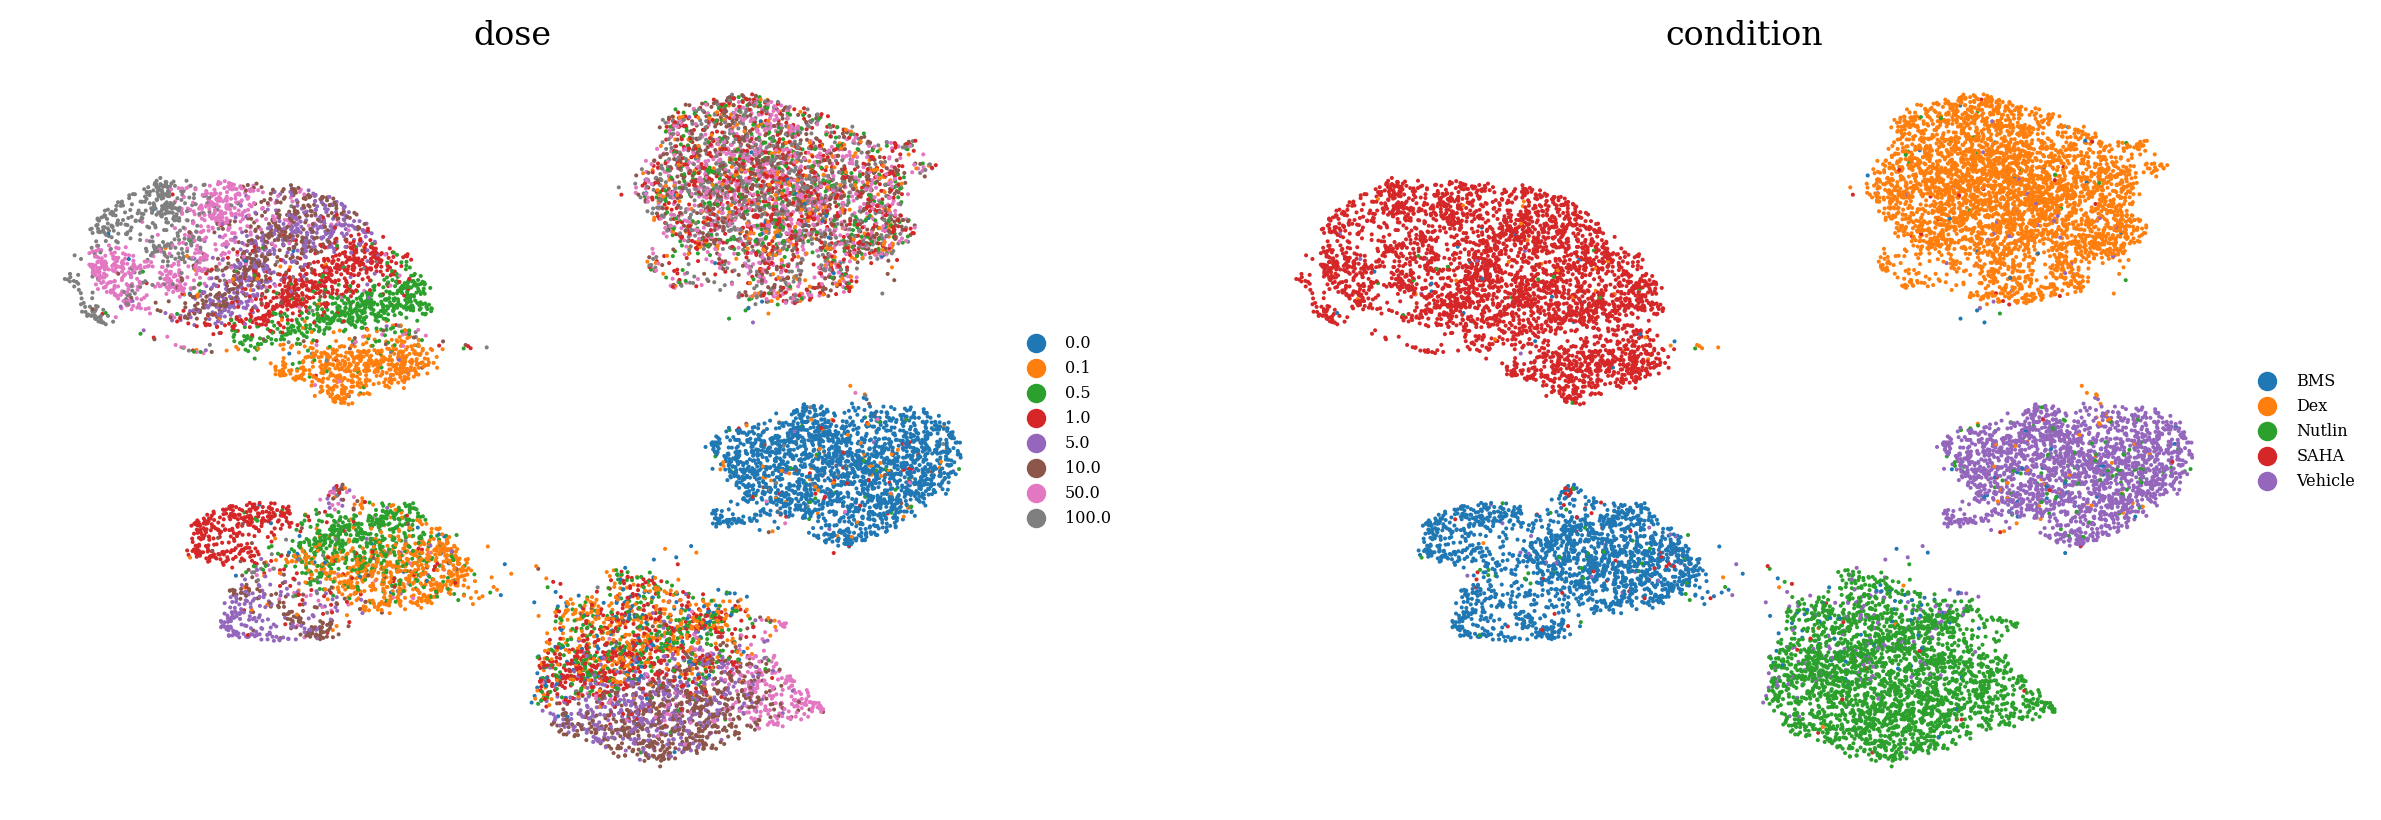

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

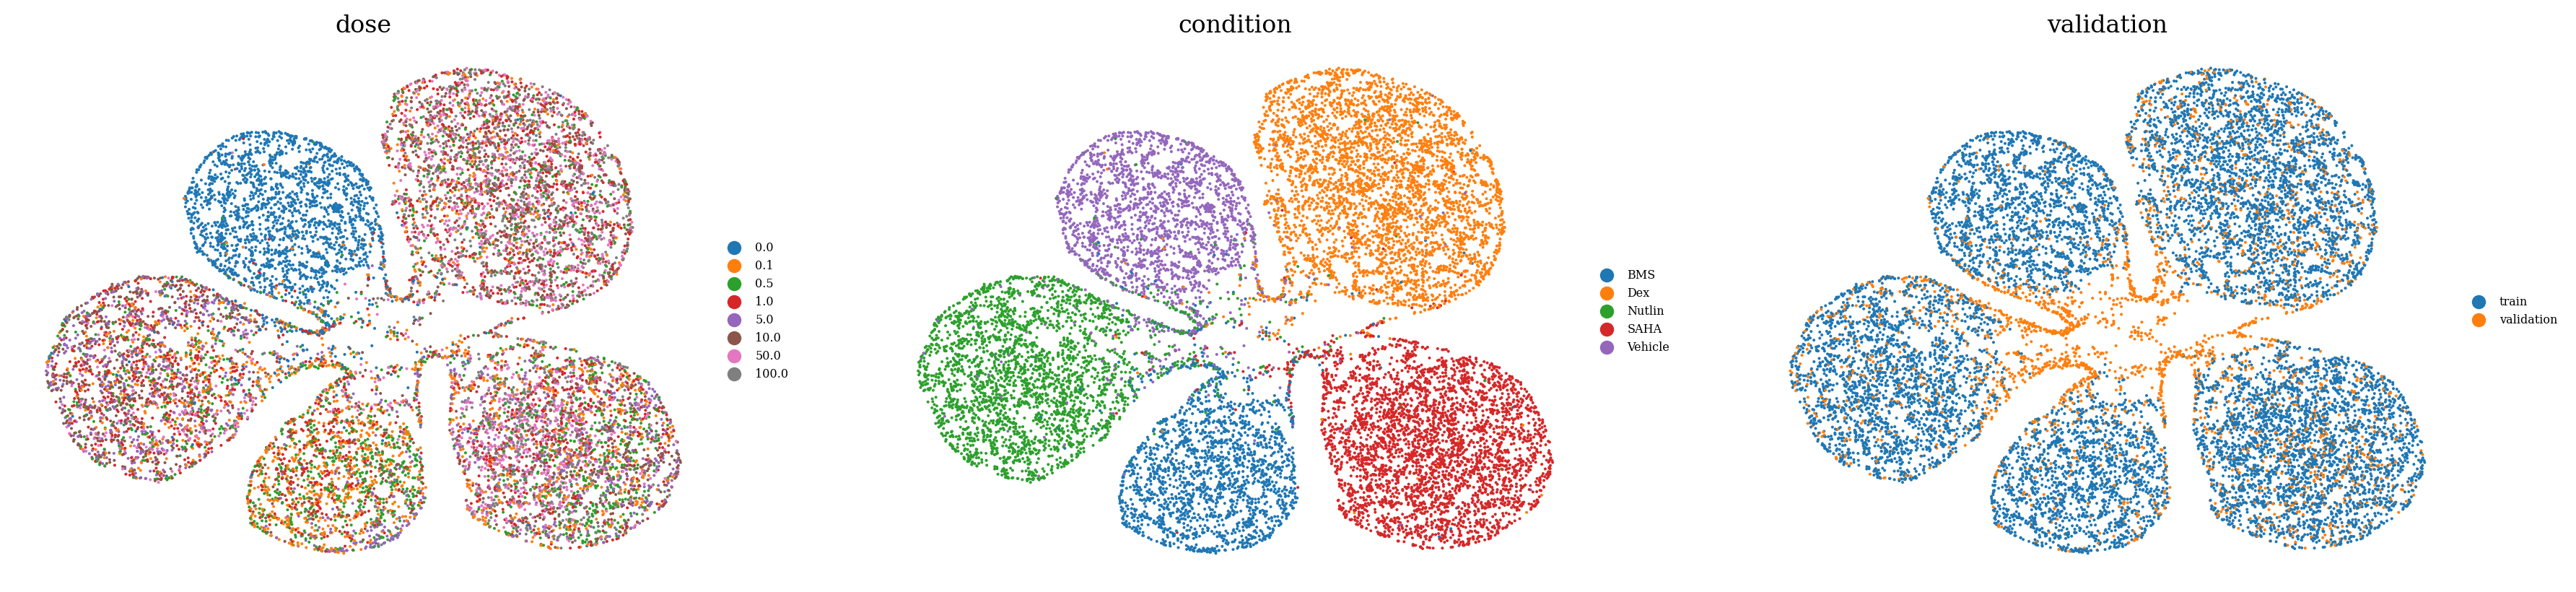

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


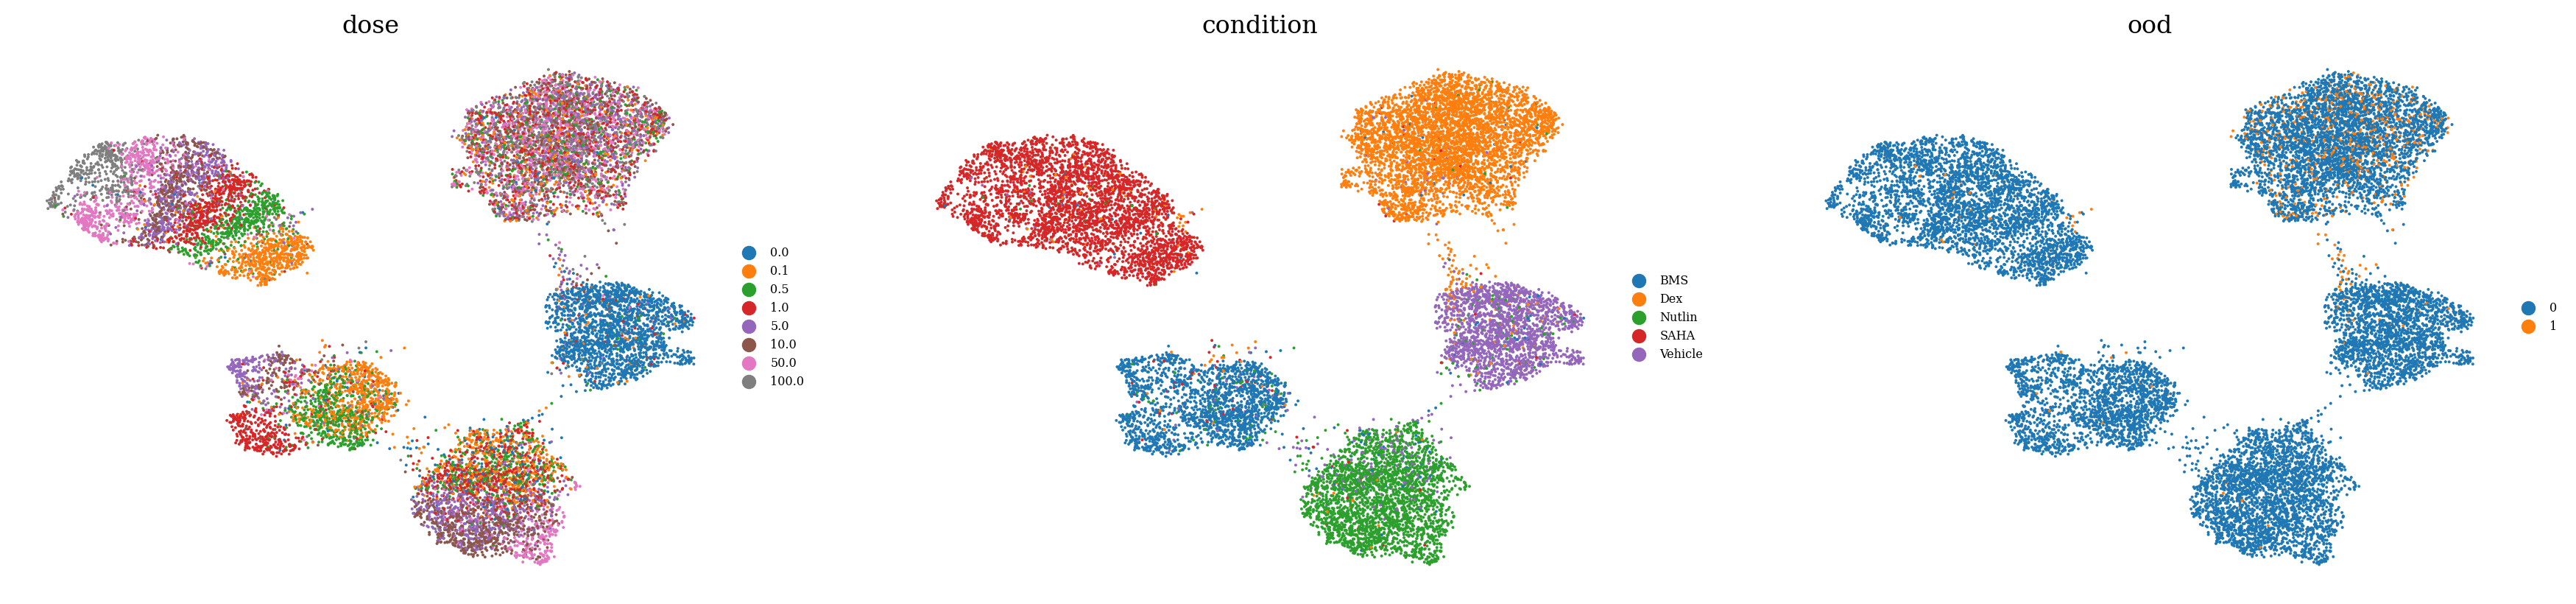

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


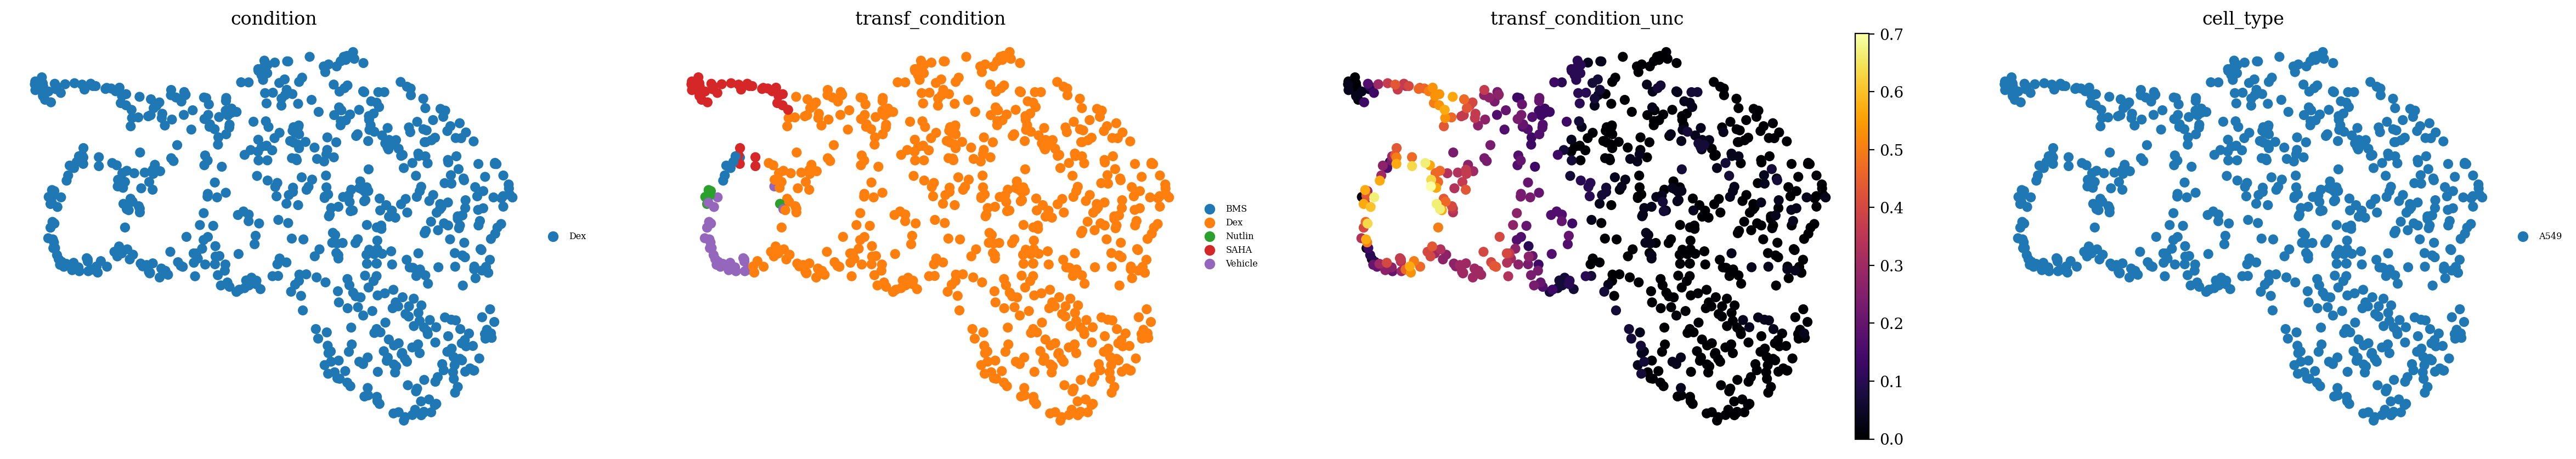

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.8832853025936599,
 'precision_macro': 0.2,
 'recall_macro': 0.17665706051873198,
 'f1_score_macro': 0.1876052027543994,
 'precision_micro': 0.8832853025936599,
 'recall_micro': 0.8832853025936599,
 'f1_score_micro': 0.8832853025936599,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8832853025936599,
 'f1_score_weighted': 0.938026013771997,
 'confusion_matrix': array([[  0,   0,   0,   0,   0],
        [  8, 613,   7,  38,  28],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.3016676794274526


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.22253730335561406
